### CSE 544 Final Project


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import gamma
import math
import datetime
import warnings
import random
import math
from itertools import permutations
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [3]:
total_cases=pd.read_csv("/content/drive/MyDrive/Prob Stats Project Data/cases.csv")
total_vaccinations=pd.read_csv("/content/drive/MyDrive/Prob Stats Project Data/vaccinations.csv")

In [4]:
total_vaccinations.rename(columns={"Location":"state"},inplace=True)
total_cases.rename(columns={"submission_date":"Date"},inplace=True)

In [5]:
total_cases.head()

,Date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,12/01/2021,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree
1,06/12/2021,AL,545637,421169.0,124468.0,130,51.0,11461,9150.0,2311.0,6,2.0,06/12/2021 12:00:00 AM,Agree,Agree
2,10/30/2021,WA,726837,NaN,NaN,1841,259.0,8628,NaN,NaN,0,0.0,10/30/2021 12:00:00 AM,NaN,NaN
3,03/28/2022,VT,107785,NaN,NaN,467,35.0,585,NaN,NaN,0,0.0,03/29/2022 01:30:11 PM,Not agree,Not agree
4,03/11/2021,MD,390490,NaN,NaN,924,0.0,8549,8345.0,204.0,19,0.0,03/13/2021 12:00:00 AM,NaN,Agree


In [6]:
def filter_data(data,states,columns):
  data=data.loc[data["state"].isin(states)]
  return data[columns].reset_index(drop=True)

In [7]:
states=["AL","CA"]
columns=["Date","state","new_case","new_death"]
cases=filter_data(total_cases,states,columns)
columns=["Date","state","Administered","Admin_Per_100K"]
vaccinations=filter_data(total_vaccinations,states,columns)

In [8]:
vaccinations.head()

,Date,state,Administered,Admin_Per_100K
0,05/15/2022,AL,6317012,128835
1,05/15/2022,CA,75794574,191826
2,05/14/2022,CA,75717825,191631
3,05/14/2022,AL,6316916,128833
4,05/13/2022,CA,75643369,191443


In [9]:
cases.head()

,Date,state,new_case,new_death
0,06/12/2021,AL,130,6
1,03/10/2020,CA,24,1
2,08/16/2020,CA,7873,110
3,06/30/2021,CA,-4359,24
4,01/11/2022,AL,12030,40


# Data Preprocessing

In [10]:
def remove_nulls(data):
  data=data[data.select_dtypes(include=[np.number]).ge(0).all(1)]
  return data.dropna(axis=0,how="any")


In [11]:
def convert_date(data):
  data['Date'] =  pd.to_datetime(data['Date'], format=r"%m/%d/%Y")
  return data

In [12]:
def sort_seperate_states(data):
  a,b=data.loc[data["state"]=="AL"],data.loc[data["state"]=="CA"]
  a.sort_values(by="Date",ignore_index=True,inplace=True)
  b.sort_values(by="Date",ignore_index=True,inplace=True)
  return a,b

In [13]:
def getMonth(data):
  data["month"]=pd.DatetimeIndex(data['Date']).month
  return data

In [14]:
from collections import Counter
import matplotlib.pyplot as plt

def remove_outliers(value,min_threshold,max_threshold):
  if value < min_threshold or value > max_threshold:
    return np.nan
  return value

def remove_all_outliers(data,columns):
  outlier_index = []
  for column in columns:
    temp_data=data[column]
    print(temp_data)
    q1=np.percentile(temp_data,25)
    q3=np.percentile(temp_data,75)
    iqr=q3-q1
    min_threshold,max_threshold=q1-(1.5*iqr),q3+(1.5*iqr)
    #Determine a list of indices of outliers for feature col
    outlier_list_col = data[(data[column] > max_threshold) | (data[column] < min_threshold)]
    print("Outliers in Column "+str(column) + " : " + str(len(outlier_list_col)))
    data[column] = data.apply(lambda x: remove_outliers(x[column],min_threshold, max_threshold), axis=1)
    plt.scatter(data['Date'],data[column])
    plt.scatter(outlier_list_col['Date'],outlier_list_col[column])
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()
  return remove_nulls(data).reset_index(drop=True)



In [15]:
def get_daily_data(data):
  data.sort_values(by="Date",ignore_index=True,inplace=True)
  t1=data["Administered"][0]
  t2=data["Admin_Per_100K"][0]
  data['Count'] = data.Administered - data.Administered.shift(1)
  data["Count_Per_100K"]=data.Admin_Per_100K-data.Admin_Per_100K.shift(1)
  data["Count"][0]=t1
  data["Count_Per_100K"]=t2
  return data



In [16]:
import seaborn as sns
def transform_data(data):
  data=remove_nulls(data)
  data=convert_date(data)
  data=getMonth(data)
  data_alaska,data_cali=sort_seperate_states(data)
  data_alaska=remove_all_outliers(data_alaska,["new_case","new_death"])
  data_cali=remove_all_outliers(data_cali,["new_case","new_death"])
  return data_alaska,data_cali

In [17]:
def transform_data_TaskA(data):
  data=remove_nulls(data)
  #data=remove_all_outliers(data,["new_case","new_death"])
  data=convert_date(data)
  data=getMonth(data)
  data_alaska,data_cali=sort_seperate_states(data)
  return data_alaska,data_cali

0        0
1        0
2        0
3        0
4        0
      ... 
838    546
839    416
840    418
841    419
842    414
Name: new_case, Length: 843, dtype: int64
Outliers in Column new_case : 68


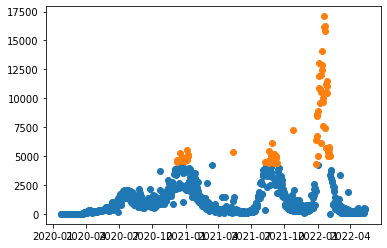

0      0
1      0
2      0
3      0
4      0
      ..
838    0
839    0
840    0
841    5
842    3
Name: new_death, Length: 843, dtype: int64
Outliers in Column new_death : 30


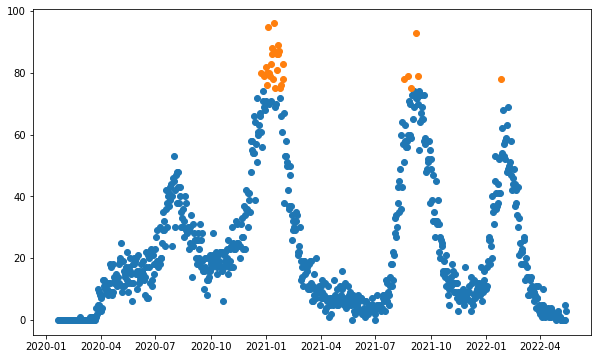

0          0
1          0
2          0
3          0
4          0
       ...  
825        0
826    33206
827        0
828        0
829    27353
Name: new_case, Length: 830, dtype: int64
Outliers in Column new_case : 92


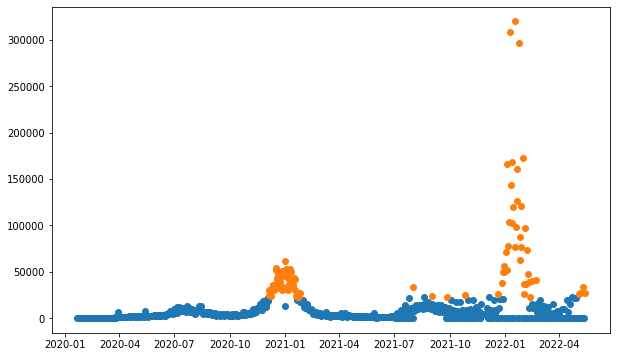

0        0
1        0
2        0
3        0
4        0
      ... 
825      0
826    106
827      0
828      0
829    160
Name: new_death, Length: 830, dtype: int64
Outliers in Column new_death : 56


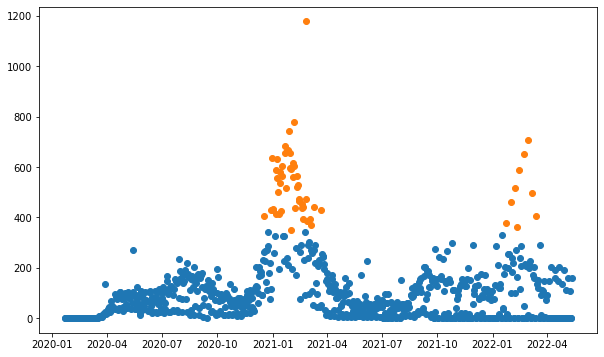

In [18]:
cases_alaska,cases_cali=transform_data(cases)


In [19]:
vaccinations.head()

,Date,state,Administered,Admin_Per_100K
0,05/15/2022,AL,6317012,128835
1,05/15/2022,CA,75794574,191826
2,05/14/2022,CA,75717825,191631
3,05/14/2022,AL,6316916,128833
4,05/13/2022,CA,75643369,191443


In [20]:
def transform_data_Vacc(data):
  data=remove_nulls(data)
  data=convert_date(data)
  data_alaska,data_cali=sort_seperate_states(data)
  data_alaska=get_daily_data(data_alaska)
  data_cali=get_daily_data(data_cali)
  data_alaska=remove_all_outliers(data_alaska,["Count","Count_Per_100K"])
  data_cali=remove_all_outliers(data_cali,["Count","Count_Per_100K"])
  return data_alaska,data_cali

0         0.0
1         0.0
2         0.0
3       193.0
4      1454.0
        ...  
513    2361.0
514    3723.0
515    3843.0
516    3740.0
517      96.0
Name: Count, Length: 518, dtype: float64
Outliers in Column Count : 13


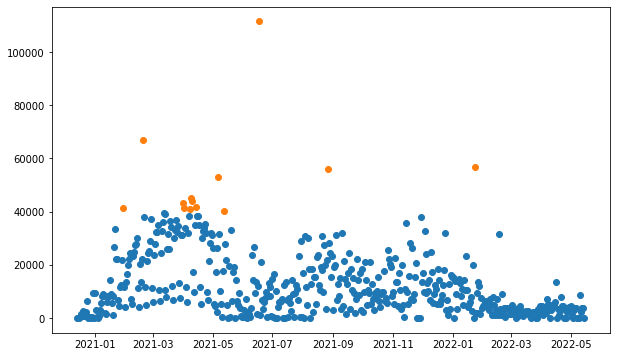

0      0
1      0
2      0
3      0
4      0
      ..
513    0
514    0
515    0
516    0
517    0
Name: Count_Per_100K, Length: 518, dtype: int64
Outliers in Column Count_Per_100K : 0


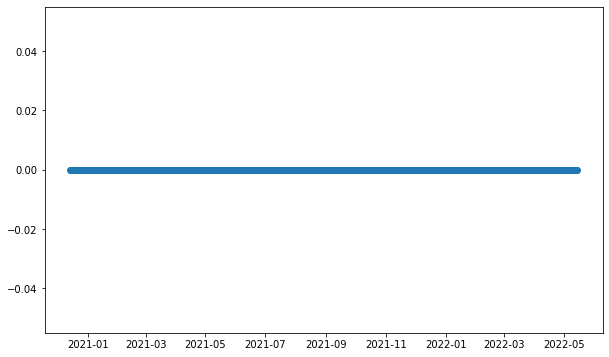

0          0.0
1          0.0
2          4.0
3        269.0
4          0.0
        ...   
513     1224.0
514    25505.0
515    61182.0
516    74456.0
517    76749.0
Name: Count, Length: 518, dtype: float64
Outliers in Column Count : 24


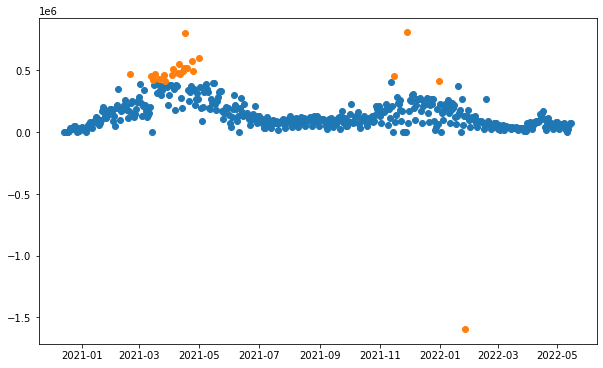

0      0
1      0
2      0
3      0
4      0
      ..
513    0
514    0
515    0
516    0
517    0
Name: Count_Per_100K, Length: 518, dtype: int64
Outliers in Column Count_Per_100K : 0


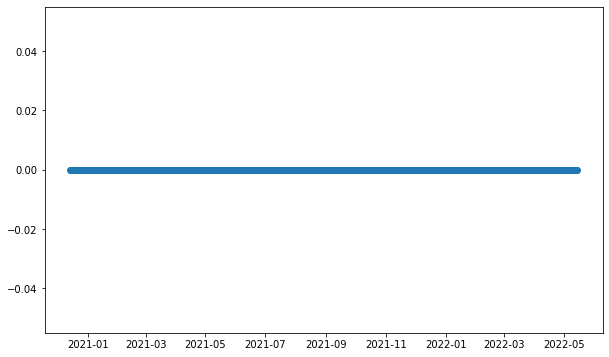

In [21]:
vaccination_alaska,vaccination_cali=transform_data_Vacc(vaccinations)

In [22]:
vaccination_alaska.head()

,Date,state,Administered,Admin_Per_100K,Count,Count_Per_100K
0,2020-12-14,AL,0,0,0.0,0
1,2020-12-15,AL,0,0,0.0,0
2,2020-12-16,AL,0,0,0.0,0
3,2020-12-17,AL,193,4,193.0,0
4,2020-12-18,AL,1647,34,1454.0,0


In [23]:
vaccination_cali.head()

,Date,state,Administered,Admin_Per_100K,Count,Count_Per_100K
0,2020-12-14,CA,0,0,0.0,0
1,2020-12-15,CA,0,0,0.0,0
2,2020-12-16,CA,4,0,4.0,0
3,2020-12-17,CA,273,1,269.0,0
4,2020-12-18,CA,273,1,0.0,0


# Task - A

In [24]:
def compute_walds_statistc(x,y):
  n=len(x)
  x_mean, y_mean, x_var, y_var = np.mean(x), np.mean(y), np.mean(x), np.mean(y)
  sd = (x_mean/n)**0.5
  #sd = np.sqrt(x_var/len(x))
  w = (x_mean - y_mean)/sd
  print("u0: "+ str(y_mean))
  print("u_hat: "+ str(x_mean))
  print("Standard error: "+ str(sd))
  print("walds statistic: "+ str(w))
  return w
def walds_test(a,b,alpha):
  w=compute_walds_statistc(a,b)
  if abs(w) < st.norm.ppf(1-(alpha/2)):
    return False
  else:
    return True

In [25]:
def compute_2Sampled_walds_statistc(x,y):
  n1=len(x)
  n2=len(y)
  x_mean, y_mean, x_var, y_var = np.mean(x), np.mean(y), np.mean(x), np.mean(y)
  sd = (x_var/n1 + y_var/n2)**0.5
  w = (x_mean - y_mean)/sd
  print("u0: "+ str(y_mean))
  print("u_hat: "+ str(x_mean))
  print("Standard error: "+ str(sd))
  print("walds statistic: "+ str(w))
  return w
def walds_2Sampled_test(a,b,alpha):
  w=compute_2Sampled_walds_statistc(a,b)
  if abs(w) < st.norm.ppf(1-(alpha/2)):
    return False
  else:
    return True

In [26]:
import scipy.stats
def compute_2Sampled_t_statistic(x,y):
  n,m=len(x),len(y)
  x_mean, y_mean, x_var, y_var = np.mean(x), np.mean(y), np.var(x), np.mean(y)
  denom=math.sqrt((x_var/n) + (y_var/m))
  corrected_variance_march = np.sum(np.square(x - x_mean))/(len(x)-1)
  corrected_variance_feb =  np.sum(np.square(y - y_mean))/(len(y)-1)
  t=(x_mean-y_mean)/np.sqrt(corrected_variance_march/len(x) + corrected_variance_feb/len(y))
  print("u0: "+ str(y_mean))
  print("u_hat: "+ str(x_mean))
  print("Standard error: "+ str(denom))
  print("T statistic: "+ str(t))
  return t
  
def t_2Sampled_test(a,b,alpha):
  t=compute_2Sampled_t_statistic(a,b)
  if abs(t)<scipy.stats.t.ppf(q=1-.05/2,df=594):
    return False
  else:
    return True


def variance(arr):
    square_sum = 0
    mean = arr.mean()
    n = len(arr)
    for i in arr:
        square_sum = square_sum + (i -mean)*(i-mean)
    return square_sum/(n-1)

In [27]:
import scipy.stats
def compute_t_statistic(x,y):
  n,m=len(x),len(y)
  x_mean, y_mean= np.mean(x), np.mean(y)
  denom = np.sqrt(variance(x)/len(x))
  t=(x_mean-y_mean)/(denom)
  print("u0: "+ str(y_mean))
  print("u_hat: "+ str(x_mean))
  print("Standard error: "+ str(denom))
  print("T statistic: "+ str(t))
  return t
  
def t_test(a,b,alpha):
  t=compute_t_statistic(a,b)
  print(scipy.stats.t.ppf(q=1-.05/2,df=29))
  if abs(t)<scipy.stats.t.ppf(q=1-.05/2,df=29):
    return False
  else:
    return True


def variance(arr):
    square_sum = 0
    mean = arr.mean()
    n = len(arr)
    for i in arr:
        square_sum = square_sum + (i -mean)*(i-mean)
    return square_sum/(n-1)

In [28]:
def compute_z_statistic(x,y):
  n,m=len(x),len(y)
  x_mean,y_mean,x_var,y_var=np.mean(x),np.mean(y),np.var(x),np.var(y)
  deno=(((x_var/n))**0.5)
  Z = (x_mean - y_mean)/deno
  print("u0: "+ str(y_mean))
  print("u_hat: "+ str(x_mean))
  print("Standard error: "+ str(deno))
  print("Z statistic: "+ str(Z))
  return Z
def ztest(a,b,alpha):
  z=compute_z_statistic(a,b)
  if abs(z)<st.norm.ppf(1-(alpha/2)):
    return False
  else:
    return True


In [29]:
cases_alaska,cases_cali=transform_data_TaskA(cases)

Hypothesis tests for California

In [30]:
feb_start_date , feb_end_date = '2021-02-01', '2021-02-28'
march_start_date, march_end_date = '2021-03-01', '2021-03-31'
condition = (cases_cali['Date'] >= feb_start_date) & (cases_cali['Date'] <= feb_end_date)
CA_feb_data = cases_cali.loc[condition]

condition = (cases_cali['Date'] >= march_start_date) & (cases_cali['Date'] <= march_end_date)
CA_march_data = cases_cali.loc[condition]


CA_feb_data=pd.DataFrame(CA_feb_data)
CA_march_data=pd.DataFrame(CA_march_data)
CA_march_data.shape

(31, 5)

Hypothesis test on mean of #Deaths different for March and Feb 21

In [31]:
walds_test(CA_march_data['new_death'],CA_feb_data['new_death'],0.05)

u0: 424.32142857142856
u_hat: 198.1290322580645
Standard error: 2.528093966825374
walds statistic: -89.47151461992634


True

In [32]:
ztest(CA_march_data['new_death'],CA_feb_data['new_death'],0.05)

u0: 424.32142857142856
u_hat: 198.1290322580645
Standard error: 21.30623754797028
Z statistic: -10.61625243800551


True

In [33]:
t_test(CA_march_data['new_death'],CA_feb_data['new_death'],0.05)

u0: 424.32142857142856
u_hat: 198.1290322580645
Standard error: 21.65843062332903
T statistic: -10.443618942072588
2.045229642132703


True

Hypothesis test on mean of #Cases different for March and Feb 21

In [34]:
walds_test(CA_march_data['new_case'],CA_feb_data['new_case'],0.05)

u0: 8293.357142857143
u_hat: 2995.6129032258063
Standard error: 9.830191976640469
walds statistic: -538.9258167307811


True

In [35]:
t_test(CA_march_data['new_case'],CA_feb_data['new_case'],0.05)

u0: 8293.357142857143
u_hat: 2995.6129032258063
Standard error: 177.59726505098553
T statistic: -29.830100357178548
2.045229642132703


True

In [36]:
ztest(CA_march_data['new_case'],CA_feb_data['new_case'],0.05)

u0: 8293.357142857143
u_hat: 2995.6129032258063
Standard error: 174.7093121775102
Z statistic: -30.32319327231201


True

## Result of Walds 1 sample testing for mean of cases and death in CA:

Null hypothesis (H0):

Mean of daily cases/deaths in CA for March’21 is different from the corresponding mean of daily values for Feb’21

Alternate hypothesis(H1):

Mean of March'21 cases/deaths in CA is same as mean of Feb'21 cases/deaths

Procedure :

We took the u0(guess value) as mean of Feb'21 cases/deaths and alpha = 0.05 as given in documentation and the MLE estimator for mean of March'21 cases/deaths becomes the smaple mean of  cases/deaths .The standard error of the estimator is calculated in above walds function.
Result:

As the w value for mean of March'21 death =89.471 which is greater than 1.96 we are Accepting the NULL hypothesis.

As the w value for mean of March'21 cases =538.925 which is greater than 1.96 we are Accepting the NULL hypothesis.



## Result of Z testing for mean of cases and death for California (CA)

Null hypothesis (H0):

Mean of March'21 cases/deaths in CA different from Mean of Feb'21 cases/deaths in CA.

Alternate hypothesis(H1):

Mean of March'21 cases/deaths in CA is same as Mean of Feb'21 cases/deaths in CA.

Result /Inference:

As the Calculated Z value for mean of March'21 deaths in CA = 10.616 which is greater than 1.96 we are accepting the NULL hypothesis.

As the Calculated Z value for mean of March'21 cases in CA = 30.323 which is greater than 1.96 we are accepting the NULL hypothesis.

Is Test Applicable ?

The main Assumptions of Z-test are the sample size has to be large or the sample data has to be normally dustributed.Here we can clearly see sample size is around 30 which satisfies the size threshold and through CLT data behaves as normal .

Hence ,We can conclude the Z Test is applicable on given dataset.



## Result of T 1 sample testing for mean of cases/death in CA:

Null hypothesis (H0):

Mean of March'21 cases/deaths is different from mean of Feb'21 cases/deaths in CA.

Alternate hypothesis(H1):

Mean of March'21 cases/deaths is same as mean of Feb'21 cases/deaths in CA.

Procedure :

We have taken the alpha = 0.05,n =30 as we took 30 days of data as given in task and calculated the numerator and denominator of T in the above T_one_sample_testing function

Result:

As the calculated value for mean of March'21 deaths in CA = 10.443 which is greater than T value 2.045 we are accepting the NULL hypothesis.

As the calculated value for mean of last week cases = 29.830 which is greater than T value 2.045 we are accepting the NULL hypothesis.

Is T-1 sample Test Applicable ?

The main assumption of T-test is the data is normally distributed, here it is not but as size n is around 30 and through CLT data behaves as T distribution. 


Hypothesis tests for Alaska

In [37]:
feb_start_date , feb_end_date = '2021-02-01', '2021-02-28'
march_start_date, march_end_date = '2021-03-01', '2021-03-31'
condition = (cases_alaska['Date'] >= feb_start_date) & (cases_alaska['Date'] <= feb_end_date)
AL_feb_data = cases_alaska.loc[condition]

condition = (cases_alaska['Date'] >= march_start_date) & (cases_alaska['Date'] <= march_end_date)
AL_march_data = cases_alaska.loc[condition]


Al_feb_data=pd.DataFrame(AL_feb_data)
AL_march_data=pd.DataFrame(AL_march_data)
AL_feb_data.shape

(28, 5)

In [38]:
walds_test(AL_march_data['new_death'],Al_feb_data['new_death'],0.05)

u0: 34.92857142857143
u_hat: 12.838709677419354
Standard error: 0.643546365911613
walds statistic: -34.325206265225


True

In [39]:
ztest(AL_march_data['new_death'],Al_feb_data['new_death'],0.05)

u0: 34.92857142857143
u_hat: 12.838709677419354
Standard error: 0.811079334064691
Z statistic: -27.2351431276761


True

In [40]:
t_test(AL_march_data['new_death'],Al_feb_data['new_death'],0.05)

u0: 34.92857142857143
u_hat: 12.838709677419354
Standard error: 0.8244865123326054
T statistic: -26.79226575660564
2.045229642132703


True

Hypothesis test on mean of #Cases different for March and Feb 21

In [41]:
walds_test(AL_march_data['new_case'],Al_feb_data['new_case'],0.05)

u0: 1205.892857142857
u_hat: 721.0967741935484
Standard error: 4.822985202580246
walds statistic: -100.51784581257847


True

In [42]:
ztest(AL_march_data['new_case'],Al_feb_data['new_case'],0.05)

u0: 1205.892857142857
u_hat: 721.0967741935484
Standard error: 138.54745468790395
Z statistic: -3.4991338097215468


True

In [43]:
t_test(AL_march_data['new_case'],Al_feb_data['new_case'],0.05)

u0: 1205.892857142857
u_hat: 721.0967741935484
Standard error: 140.83765041297264
T statistic: -3.442233532920781
2.045229642132703


True

## **Result of Walds 1 sample testing for mean of cases and death in Alaska(AL):**

Null hypothesis (H0):

Mean of daily cases/deaths in AL for March’21 is different from the corresponding mean of daily values for Feb’21

Alternate hypothesis(H1):

Mean of March'21 cases/deaths in AL is same as mean of Feb'21 cases/deaths

Procedure :

We took the u0(guess value) as mean of Feb'21 cases/deaths and alpha = 0.05 as given in documentation and the MLE estimator for mean of March'21 cases/deaths becomes the smaple mean of  cases/deaths .The standard error of the estimator is calculated in above walds function.
Result:

As the w value for mean of March'21 death =34.325 which is greater than 1.96 we are Accepting the NULL hypothesis.

As the w value for mean of March'21 cases =100.517 which is greater than 1.96 we are Accepting the NULL hypothesis.



## Result of Z testing for mean of cases and death for Alaska (AL)

Null hypothesis (H0):

Mean of March'21 cases/deaths in AL different from Mean of Feb'21 cases/deaths in AL.

Alternate hypothesis(H1):

Mean of March'21 cases/deaths in AL is same as Mean of Feb'21 cases/deaths in AL.

Result /Inference:

As the Calculated Z value for mean of March'21 deaths in AL = 27.235 which is greater than 1.96 we are accepting the NULL hypothesis.

As the Calculated Z value for mean of March'21 cases in CA = 3.499 which is greater than 1.96 we are accepting the NULL hypothesis.

Is Test Applicable ?

The main Assumptions of Z-test are the sample size has to be large or the sample data has to be normally dustributed.Here we can clearly see sample size is around 30 which satisfies the size threshold and through CLT data behaves as normal .

Hence ,We can conclude the Z Test is applicable on given dataset.



## Result of T 1 sample testing for mean of cases/death in AL:

Null hypothesis (H0):

Mean of March'21 cases/deaths is different from mean of Feb'21 cases/deaths in AL.

Alternate hypothesis(H1):

Mean of March'21 cases/deaths is same as mean of Feb'21 cases/deaths in AL.

Procedure :

We have taken the alpha = 0.05,n =30 as we took 30 days of data as given in task and calculated the numerator and denominator of T in the above T_one_sample_testing function

Result:

As the calculated value for mean of March'21 deaths in AL = 26.792 which is greater than T value 2.045 we are accepting the NULL hypothesis.

As the calculated value for mean of last week cases = 3.442 which is greater than T value 2.045 we are accepting the NULL hypothesis.

Is T-1 sample Test Applicable ?

The main assumption of T-test is the data is normally distributed, here it is not but as size n is around 30 and through CLT data behaves as T distribution. 


Wald's 2 sample test

In [44]:
walds_2Sampled_test(AL_march_data['new_death'],Al_feb_data['new_death'],0.05)

u0: 34.92857142857143
u_hat: 12.838709677419354
Standard error: 1.2890309944566425
walds statistic: -17.13679643557639


True

In [45]:
walds_2Sampled_test(AL_march_data['new_case'],Al_feb_data['new_case'],0.05)

u0: 1205.892857142857
u_hat: 721.0967741935484
Standard error: 8.1442487870352
walds statistic: -59.52618781993175


True

In [46]:
walds_2Sampled_test(CA_march_data['new_death'],CA_feb_data['new_death'],0.05)

u0: 424.32142857142856
u_hat: 198.1290322580645
Standard error: 4.641723369589439
walds statistic: -48.730262082242696


True

In [47]:
walds_2Sampled_test(CA_march_data['new_case'],CA_feb_data['new_case'],0.05)

u0: 8293.357142857143
u_hat: 2995.6129032258063
Standard error: 19.819788112596434
walds statistic: -267.295705157633


True

## **Result of Walds 2 sampled test for mean of cases and death in Alaska(AL) and California(CA):**

Null hypothesis (H0):

Mean of daily cases/deaths in AL/CA for March’21 is different from the corresponding mean of daily values for Feb’21

Alternate hypothesis(H1):

Mean of March'21 cases/deaths in AL/CA is same as mean of Feb'21 cases/deaths

Procedure :

We took the u0(guess value) as mean of Feb'21 cases/deaths and alpha = 0.05 as given in documentation and the MLE estimator for mean of March'21 cases/deaths becomes the smaple mean of  cases/deaths .The standard error of the estimator is combination of the standard error of both the time frame data March and Feb.

Result:

As the w statistic value for deaths in AL =17.1367 which is greater than 1.96 we are Accepting the NULL hypothesis.

As the w  statistic value for cases in AL =59.526 which is greater than 1.96 we are Accepting the NULL hypothesis.


As the w statistic value for death in CA =48.730 which is greater than 1.96 we are Accepting the NULL hypothesis.

As the w statistic value for cases in CA =267.295 which is greater than 1.96 we are Accepting the NULL hypothesis.


Unpaired 2-sample T-test

In [48]:
t_2Sampled_test(AL_march_data['new_death'],Al_feb_data['new_death'],0.05)

u0: 34.92857142857143
u_hat: 12.838709677419354
Standard error: 1.3803255651253654
T statistic: -9.343315258095158


True

In [49]:
t_2Sampled_test(AL_march_data['new_case'],Al_feb_data['new_case'],0.05)

u0: 1205.892857142857
u_hat: 721.0967741935484
Standard error: 138.70279305961225
T statistic: -2.760831681027988


True

In [50]:
t_2Sampled_test(CA_march_data['new_case'],CA_feb_data['new_case'],0.05)

u0: 8293.357142857143
u_hat: 2995.6129032258063
Standard error: 175.55493467307983
T statistic: -7.767307805822794


True

In [51]:
t_2Sampled_test(CA_march_data['new_death'],CA_feb_data['new_death'],0.05)

u0: 424.32142857142856
u_hat: 198.1290322580645
Standard error: 21.65894954020699
T statistic: -4.811635689154416


True


## Result of T 2 sample unpaired testing for mean of cases and death for CA/AL

Null hypothesis (H0):

Mean of March'21 cases/deaths in CA/AL is different from Mean of Feb'21 cases/deaths.

Alternate hypothesis(H1):

mean of March'21 cases/deaths in CA/AL is same as mean of Feb'21 cases/deaths.

Procedure :

We have taken the alpha = 0.05 n=30, m=28 as given in task and calculated the numerator and denominator of T value in the above t_2Sampled_test function .

Result:

As the T-Statistic value for cases in CA = 7.767 which is greater than 2.18 we are accpeting the NULL hypothesis.

As the T-Statistic value cases in AL = 2.760 which is less than 2.18 we are accpeting the NULL hypothesis.

As the T-statistic value for deaths in AL = 9.343 which is greater than 2.18 we are accepting the NULL hypothesis.

As the T-statistic value for deaths in CA = 4.811 which is greater than 2.18 we are accepting the NULL hypothesis.


# Task - B

0        0
1        0
2        0
3        0
4        0
      ... 
838    546
839    416
840    418
841    419
842    414
Name: new_case, Length: 843, dtype: int64
Outliers in Column new_case : 68


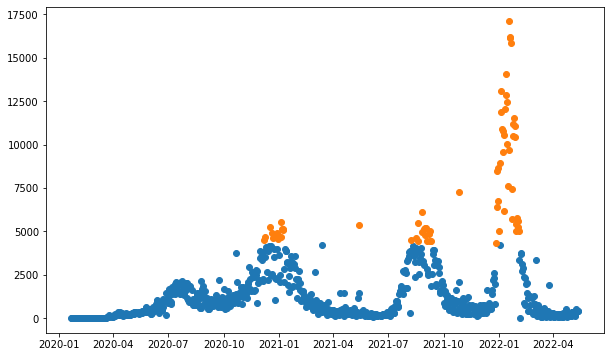

0      0
1      0
2      0
3      0
4      0
      ..
838    0
839    0
840    0
841    5
842    3
Name: new_death, Length: 843, dtype: int64
Outliers in Column new_death : 30


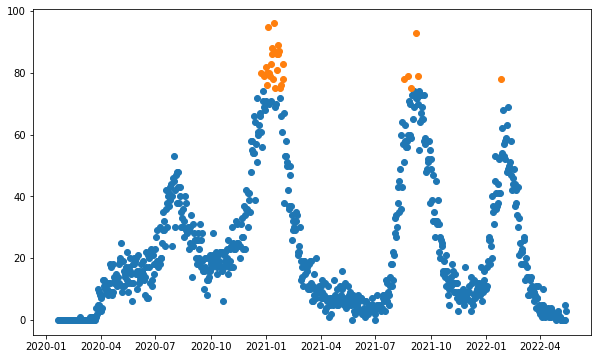

0          0
1          0
2          0
3          0
4          0
       ...  
825        0
826    33206
827        0
828        0
829    27353
Name: new_case, Length: 830, dtype: int64
Outliers in Column new_case : 92


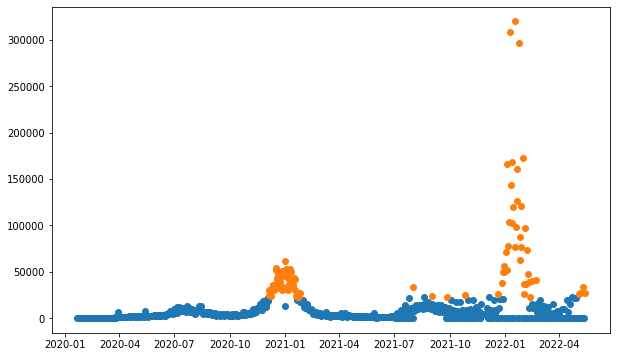

0        0
1        0
2        0
3        0
4        0
      ... 
825      0
826    106
827      0
828      0
829    160
Name: new_death, Length: 830, dtype: int64
Outliers in Column new_death : 56


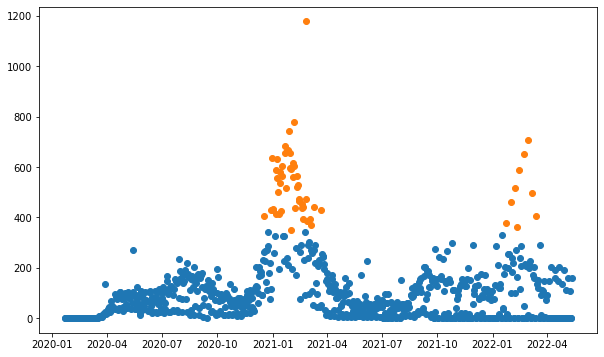

In [52]:
cases_alaska,cases_cali=transform_data(cases)

In [53]:
cases_alaska_b=cases_alaska.loc[(cases_alaska["month"].isin([10,11,12]))& (cases_alaska["Date"].dt.year==2021)].reset_index(drop=True)
cases_cali_b=cases_cali.loc[(cases_cali["month"].isin([10,11,12]))&(cases_cali["Date"].dt.year==2021)].reset_index(drop=True)

In [54]:
cases_cali_b

,Date,state,new_case,new_death,month
0,2021-10-01,CA,7869.0,126.0,10
1,2021-10-02,CA,0.0,0.0,10
2,2021-10-03,CA,0.0,0.0,10
3,2021-10-04,CA,18998.0,243.0,10
4,2021-10-06,CA,5386.0,157.0,10
...,...,...,...,...,...
79,2021-12-23,CA,20417.0,102.0,12
80,2021-12-24,CA,20401.0,78.0,12
81,2021-12-25,CA,0.0,0.0,12
82,2021-12-26,CA,0.0,0.0,12


## Permutation Test Function

The permutation test is used to check whether two data samples follow the same distribution

**Result of Permutation test for two state cases**

**Null hypothesis (H0):**
Distribution of state Alaska cases equals distribution of state California cases

**Alternate hypothesis(H1):**
Distribution of state Alaska cases not equals to distribution of  state California cases



**Procedure :**
We permutted all Alaska state records and California records data 1000 ways.
We take alpha = 0.05, as stated in the documentation, and calculate it.
  

**Is the Permutation Test appliable ?**

There as no assumptions under KS test, hence the test is applicable 






In [55]:
def generate_data(l,a,b,T_obs):
  print("T_obs",T_obs)
  def find_xmean(row):
    return sum(row["X"])/len(row["X"])
  def find_ymean(row):
    return sum(row["Y"])/len(row["Y"])
  def finddiff(row):
    return round(abs(row["X_mean"]-row["Y_mean"]),2)
  def solve(row):
    return 1 if row["T = |X_mean - Y_mean |"] > T_obs else 0
  n=len(l)
  X,Y=[],[]
  for i in range(n):
    X.append(l[i][:a])
    Y.append(l[i][a:])
  data=pd.DataFrame()
  
  data["X"],data["Y"]=X,Y
  data["X_mean"] = data.apply(find_xmean, axis = 1)
  data["Y_mean"] = data.apply(find_ymean, axis = 1)
  data["T = |X_mean - Y_mean |"] = data.apply(finddiff,axis = 1)
  data["I (T > T_obs)"] = data.apply(solve,axis = 1)
  return data

In [56]:
def perm_generator(seq):
  seen = set()
  length = len(seq)
  while True:
      perm = tuple(random.sample(seq, length))
      if perm not in seen:
          seen.add(perm)
          yield perm          

In [57]:
def p_value(data):
  return data.iloc[:,-1].sum()/len(data)

In [58]:
def get_p_value(data_alaska,data_cali,n):
  a,b=len(data_alaska),len(data_cali)
  data=data_alaska+data_cali
  rand_perms = perm_generator(data)
  permlist= [next(rand_perms) for _ in range(n)]
  permlist=list(map(list,permlist))
  T_obs = abs(np.mean(data_alaska)-np.mean(data_cali))
  data=generate_data(permlist,a,b,T_obs)
  return p_value(data)

In [59]:
def permutation_test(X,Y,alpha):
  a,b = len(X),len(Y)
  n=min(math.factorial(a+b),1000)
  p=get_p_value(X,Y,n)
  print("P Value:",p)
  if p < alpha :
    return False
  else:
    return True

In [60]:
permutation_test(list(cases_alaska_b["new_case"]),list(cases_cali_b["new_case"]),0.05)

T_obs 5184.264396456257
P Value: 0.0


False

In [61]:
permutation_test(list(cases_alaska_b["new_death"]),list(cases_cali_b["new_death"]),0.05)

T_obs 60.69269102990034
P Value: 0.0


False

## K-S One Sample Test#

In [62]:
def eCDF_value(state1):
    state_l = len(state1)
    l = sorted(state1)
    delta = .1
    X = []
    f_x = [0]
    for i in range(0,state_l):
        X = X + [l[i]]
        f_x = f_x + [f_x[len(f_x)-1]+(1/state_l)]
    f_x = f_x + [1]
    return X,f_x

In [63]:
def one_sample_ks_test(X,f_x, CDF, parameter,distribution):
    maximum_value = -1000
        
    list = np.zeros((len(X),4))
    for i in range(len(list)):
        list[i,0] = f_x[i]
        list[i,1] = f_x[i+1]

        F_x = CDF(parameter, X[i],distribution)
        list[i,2] = abs(list[i,0] - F_x)
        list[i,3] = abs(list[i,1] - F_x)
        cmax = max(list[i,2], list[i,3])
        if cmax > maximum_value:
            maximum_value = cmax
        
        
    return maximum_value

##KS test for distribution of daily cases#

In [64]:
# Obtaining eCDF for state Alaska
state1_data =cases_alaska_b["new_case"]
x,f_x  = eCDF_value(state1_data)

In [65]:
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom

def CDF_Distribution(parameter, x,distribution):
  if distribution=='Poisson':
    return poisson.cdf(x, parameter)
  elif distribution=='geometric':
    return geom.cdf(x, parameter)
  elif distribution=='binomial':
    return binom.cdf(x, parameter[0], parameter[1])




In [66]:
def MME_Distribution(x ,distribution):
  if distribution=='Poisson':
    return np.mean(x)
  elif distribution=='geometric':
    samplemean=np.mean(x)
    estimator=1/samplemean
    return estimator
  elif distribution=='binomial':
    samplemean=np.mean(x)
    variance = np.var(x)
    estimated_p= 1-(variance/samplemean)
    estimated_n=samplemean/estimated_p
    return estimated_p,estimated_n


***KS-test one sample test on cases***

###  Result of 1 sample KS test for for the last three months covid cases of 2021 with Poisson distribution###

**Null hypothesis (H0):** 
Distribution of Oct-Dec 2021 cases equals poisson distribution
**Alternate hypothesis(H1):**
Distribution of Oct-Dec 2021 cases not equals poisson distribution

**Procedure :**
We  obtained the parameters for the Poisson distribution  using MME on the second state data.
We take c = 0.05 as reported in the literature and calculate the maximum difference in the CDF of the distributions at all  points.

**Is  KS testing applicable?**
There are no assumptions in the KS test, so the test is applicable


**Poisson distribution :**

In [67]:
lambda_value=MME_Distribution(cases_cali_b["new_case"],'Poisson')
print(' Poisson distribution parameter lambda : ', lambda_value)

 Poisson distribution parameter lambda :  5988.869047619048


In [68]:
KS_statistical_value= one_sample_ks_test(x , f_x , CDF_Distribution, lambda_value,'Poisson')

print('KS test statistical value : ', KS_statistical_value)

KS test statistical value :  1.000000000000001


## **Result**

Since the statistical value of the KS test is ***1.000000000000001***, greater than 0.05, we **reject** the null hypothesis.

Oct-Dec 2021 data for the second state does not follow the poisson distribution.

**Geometric distribution :**

###  Result of 1 sample KS test for for the last three months of 2021 with Geometric distribution###

**Null hypothesis (H0):** 
Distribution of Oct-Dec 2021 cases equals geometric distribution
**Alternate hypothesis(H1):**
Distribution of Oct-Dec 2021 cases not equals geometric distribution

**Procedure :**
We  obtained the parameters for the Geometric distribution  using MME on the second state data.
We take c = 0.05 as reported in the literature and calculate the maximum difference in the CDF of the distributions at all  points.


In [69]:
p_value=MME_Distribution(cases_cali_b["new_case"],'geometric')
print(' Geometric distribution parameter p : ', p_value)

 Geometric distribution parameter p :  0.00016697643445677993


In [70]:
KS_statistical_value_g= one_sample_ks_test(x , f_x , CDF_Distribution, p_value,'geometric')

print('KS test statistical value : ', KS_statistical_value_g)

KS test statistical value :  0.703821139489093


## **Result**

Since the statistical value of the KS test is ***0.7038***, greater than 0.05, we **reject** the null hypothesis.

Oct-Dec 2021 data for the second state does not follow the geometric distribution.

**Binomial distribution :**

In [71]:
n,p =MME_Distribution(cases_cali_b["new_case"],'binomial')
print(' Binomial distribution parameter n & p : ', n,p )

 Binomial distribution parameter n & p :  -6083.316351882009 -0.9844743723982492


In [72]:
KS_statistical_value_b= one_sample_ks_test(x , f_x , CDF_Distribution, [n,p],'binomial')

print('KS test statistical value : ', KS_statistical_value_b)

KS test statistical value :  1.0


## **Result**

Since the statistical value of the KS test is ***1***, greater than 0.05, we **reject** the null hypothesis.

Oct-Dec 2021 data for the second state does not follow the binomial distribution.


##KS test for daily death distribution#

###  Result of 1 sample KS test for for the last three months covid deaths of 2021 with Poisson distribution###

**Null hypothesis (H0):** 
Distribution of Oct-Dec 2021 deaths equals poisson distribution

**Alternate hypothesis(H1):**
Distribution of Oct-Dec 2021 deaths not equals poisson distribution

**Procedure :**
We  obtained the parameters for the Poisson distribution  using MME on the second state data.
We take c = 0.05 as reported in the literature and calculate the maximum difference in the CDF of the distributions at all  points.

**Is  KS testing applicable?**
There are no assumptions in the KS test, so the test is applicable


In [73]:
# Obtaining eCDF for Alaska
state1_data_deaths =cases_alaska_b["new_death"]
x_death,f_x_death  = eCDF_value(state1_data)

**Poisson distribution :**

In [74]:
lambda_value=MME_Distribution(cases_cali_b["new_death"],'Poisson')
print(' Poisson distribution parameter lambda : ', lambda_value)

 Poisson distribution parameter lambda :  76.28571428571429


In [75]:
KS_statistical_value_deaths= one_sample_ks_test(x_death , f_x_death , CDF_Distribution, lambda_value,'Poisson')

print('KS test statistical value : ', KS_statistical_value_deaths)

KS test statistical value :  0.9947056956031555


## **Result**

Since the statistical value of the KS test is ***0.99***, greater than 0.05, we **reject** the null hypothesis.

Oct-Dec 2021 data for the second state deaths data does not follow the poisson distribution.


**Geometric distribution :**

In [76]:
p_value=MME_Distribution(cases_cali_b["new_death"],'geometric')
print(' Geometric distribution parameter p : ', p_value)

 Geometric distribution parameter p :  0.013108614232209737


In [77]:
KS_statistical_value_g_death= one_sample_ks_test(x_death , f_x_death, CDF_Distribution, p_value,'geometric')

print('KS test statistical value : ', KS_statistical_value_g_death)

KS test statistical value :  0.9080406474926086


## **Result**

Since the statistical value of the KS test is ***0.908***, greater than 0.05, we **reject** the null hypothesis.


Oct-Dec 2021 data for the second state deaths data does not follow the geometric distribution.

**Binomial distribution :**

In [78]:
n,p =MME_Distribution(cases_cali_b["new_death"],'binomial')
print(' Binomial distribution parameter n & p : ', n,p )

 Binomial distribution parameter n & p :  -72.41809345461033 -1.0534068303459008


In [79]:
KS_statistical_value_b_death= one_sample_ks_test(x_death , f_x_death, CDF_Distribution, [n,p],'binomial')

print('KS test statistical value : ', KS_statistical_value_b_death)

KS test statistical value :  1.0


## **Result**

Since the statistical value of the KS test is ***1.0***, greater than 0.05, we **reject** the null hypothesis.

Oct-Dec 2021 data for the second state deaths data does not follow the binomial distribution.

## **KS 2-sample Test**

**KS test for distribution of daily cases**


**Result of 2 sample KS test for the equality of distributions between the two states(cases)**


**Null hypothesis (H0):**
Distribution of Oct-Dec 2021 cases of state Alaska equals  distribution of Oct-Dec 2021 cases of state California.

**Alternate hypothesis(H1):**
Distribution of Oct-Dec 2021 cases of state Alaska not equals distribution of Oct-Dec 2021 cases of state California.

**Procedure :**
We take c = 0.05 as reported in the literature and calculate the maximum difference in the CDF of the distributions at all points.

**Is the KS Test appliable ?**
There as no assumptions under KS test, hence the test is applicable 

In [80]:
def eCDF_value(state1):
    state_1 = len(state1)
    listvalues = sorted(state1)
    value=1/(state_1)
    X = []
    f_x = []
    cdf=value

    for i in range(0,state_1):
        X = X + [listvalues[i]]
        f_x = f_x + [cdf]
        cdf+=value

    return X,f_x

In [81]:
def ks_test(state1,state2,X1, f_X1, X2, f_X2):
  i=0
  j=0
  maxi1=0
  while i<len(state1) and j<len(state2):
    if state1[i] < state2[j]:
      if j==0:
        F_x_cap=0
      else:
        F_x_cap = f_X2[X2.index(state2[j-1])]
      if i==0:
        F_y_left=0
      else:
        F_y_left = f_X1[X1.index(X1[i-1])]
      if i==len(X1)-1:
        F_y_right=1
      else:
        F_y_right=f_X1[X1.index(state1[i])]
      maxi_temp=max(abs(F_x_cap-F_y_left),abs(F_x_cap-F_y_right))
      if maxi_temp>maxi1:
        maxi1=maxi_temp
        index=i
      i+=1
    else:
      j+=1

  print("K-S statistic is " + str(maxi1)+" and point of max difference is "+str(state1[index]))
  return maxi1


K-S statistic is 1.000000000000001 and point of max difference is 2582.0
KS statistic :  1.000000000000001


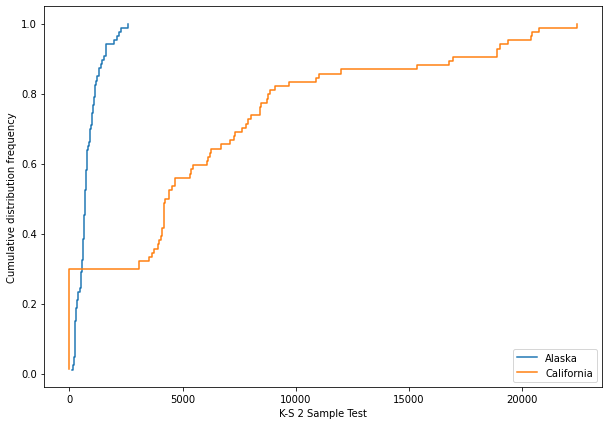

In [82]:
# Obtaining eCDF for cases
state1_data = cases_alaska_b["new_case"]

state2_data = cases_cali_b["new_case"]

X1, f_X1 = eCDF_value(state1_data)
X2, f_X2 = eCDF_value(state2_data)


KS_p_value_deaths = ks_test(state1_data.tolist(), state2_data.tolist(),X1, f_X1, X2, f_X2)

print('KS statistic : ', KS_p_value_deaths)
plt.figure('K-S test' , figsize=(10,7))
plt.xlabel("K-S 2 Sample Test")
plt.ylabel('Cumulative distribution frequency')
    
plt.step(X1, f_X1, where='post', label="Alaska")
plt.step(X2, f_X2, where='post', label="California")
plt.legend()
plt.show()


## **Result**

Since the statistical value of the KS test is ***0.978***, greater than 0.05, we **reject** the null hypothesis.

 The distribution of Oct-Dec 2021 cases of state Alaska does not equal the distribution of Oct-Dec 2021 cases of state California.

**KS test for distribution of daily deaths**


**Result of 2 sample KS test for the equality of distributions between the two states(deaths)**


**Null hypothesis (H0):**
Distribution of Oct-Dec 2021 deaths of state Alaska equals  distribution of Oct-Dec 2021 deaths of state California.

**Alternate hypothesis(H1):**
Distribution of Oct-Dec 2021 deaths of state Alaska not equals distribution of Oct-Dec 2021 deaths of state California.

**Procedure :**
We take c = 0.05 as reported in the literature and calculate the maximum difference in the CDF of the distributions at all points.


K-S statistic is 1.000000000000001 and point of max difference is 52.0
KS statistic :  1.000000000000001


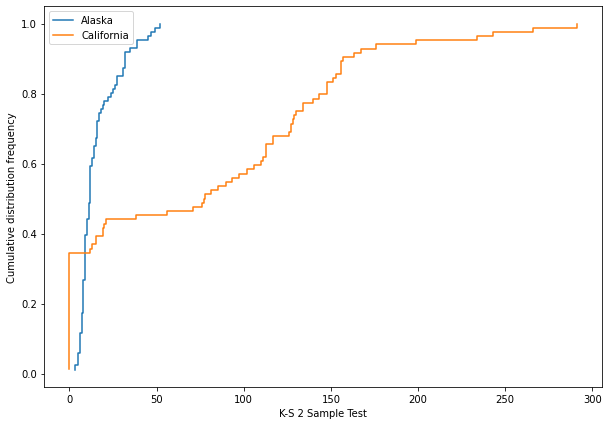

In [83]:
# Obtaining eCDF for deaths
state1_data = cases_alaska_b["new_death"]

state2_data = cases_cali_b["new_death"]

X1, f_X1 = eCDF_value(state1_data)
X2, f_X2 = eCDF_value(state2_data)


KS_p_value_deaths = ks_test(state1_data.tolist(), state2_data.tolist(),X1, f_X1, X2, f_X2)

print('KS statistic : ', KS_p_value_deaths)
plt.figure('K-S test' , figsize=(10,7))
plt.xlabel("K-S 2 Sample Test")
plt.ylabel('Cumulative distribution frequency')
    
plt.step(X1, f_X1, where='post', label="Alaska")
plt.step(X2, f_X2, where='post', label="California")
plt.legend()
plt.show()


## **Result**

Since the statistical value of the KS test is ***1.00***, greater than 0.05, we **reject** the null hypothesis.

 The distribution of Oct-Dec 2021 deaths of state Alaska does not equal the distribution of Oct-Dec 2021 deaths of state California.

# Task C

In [84]:
# This function is to merge the data from both states adding the cases and deaths
def merge(cases_alaska,cases_cali):
  cases1=cases_alaska.drop(["state"],axis=1)
  cases2=cases_cali.drop(["state"],axis=1)
  cases=pd.merge(cases1, cases2, how ='inner', on =["Date"])
  cases["Cases"]=cases["new_case_x"]+cases["new_case_y"]
  cases["Deaths"]=cases["new_death_x"]+cases["new_death_y"]
  return cases.drop(["new_case_x","new_case_y","new_death_x","new_death_y","month_x","month_y"],axis=1)

In [85]:
cases=merge(cases_alaska,cases_cali)

In [86]:
#getting the june data
june_data=cases.loc[(cases["Date"].dt.month==6) & (cases["Date"].dt.year==2020)].reset_index(drop=True)

In [87]:
lambd=np.mean(june_data["Cases"])

In [88]:
#This function generate the parameters for posterior Gamma Distribution
def generate_posterior(exp1,exp2,lambda1,lambda_2):
    return exp1+exp2,lambda1+lambda2


In [89]:

lambd= np.mean(june_data["Cases"])
print(' MME of poisson distributed data ', lambd)
exp_lambda = 1/lambd 
print(' Prior beta value ', exp_lambda)
start_date=datetime.datetime(2020,6,29)
end_date=start_date+datetime.timedelta(days=7)
posterior_data=cases.loc[(cases["Date"]>=start_date) & (cases["Date"]<end_date)].reset_index(drop=True)["Cases"]
exp1= len(posterior_data)
lambda1= np.sum(posterior_data)  
exp2= exp_lambda
lambda2=0
parameters = []
for i in range(4):
  print(start_date,end_date)
  exp2,lambda2 = generate_posterior(exp1,exp2,lambda1,lambda2)
  parameters.append([lambda2 + 1,exp2])
  start_date=end_date
  end_date=end_date+datetime.timedelta(days=7)
  posterior_data=cases.loc[(cases["Date"]>=start_date) & (cases["Date"]<end_date)].reset_index(drop=True)["Cases"]
  exp1 = len(posterior_data)
  lamda1 = np.sum(posterior_data)

 MME of poisson distributed data  4418.733333333334
 Prior beta value  0.00022630919871456374
2020-06-29 00:00:00 2020-07-06 00:00:00
2020-07-06 00:00:00 2020-07-13 00:00:00
2020-07-13 00:00:00 2020-07-20 00:00:00
2020-07-20 00:00:00 2020-07-27 00:00:00


In [90]:
#this function is to plot the gamma distribution from given parameters
def plot_gamma(parameters):
    for parameter in parameters:
        alpha, beta = parameter[0], parameter[1]
        x = np.linspace(gamma.ppf(0.01, alpha, scale=1/beta),gamma.ppf(0.99, alpha,scale = 1/beta), 100)
        MAP = (alpha)/beta
        plt.plot(x, gamma.pdf(x, alpha,scale=1/beta), label = 'MAP: %.4f ' %(MAP))
        plt.xlabel('X')
        plt.ylabel('Distribution')
    plt.legend()
    plt.show()

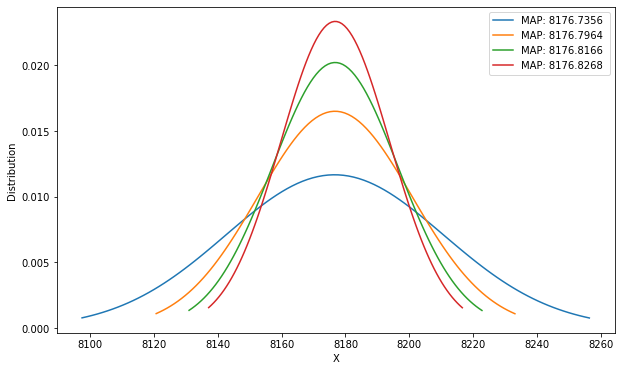

In [91]:
plot_gamma(parameters)

In [92]:
lambd= np.mean(june_data["Deaths"])
print(' MME of poisson distributed data ', lambd)
exp_lambda = 1/lambd 
print(' Prior beta value ', exp_lambda)
start_date=datetime.datetime(2020,6,29)
end_date=start_date+datetime.timedelta(days=7)
posterior_data=cases.loc[(cases["Date"]>=start_date) & (cases["Date"]<end_date)].reset_index(drop=True)["Deaths"]
exp1= len(posterior_data)
lambda1= np.sum(posterior_data)  
exp2= exp_lambda
lambda2=0

table = []
for i in range(4):
  print(start_date,end_date)
  exp2,lambda2 = generate_posterior(exp1,exp2,lambda1,lambda2)
  table.append([lambda2 + 1,exp2])
  start_date=end_date
  end_date=end_date+datetime.timedelta(days=7)
  posterior_data=cases.loc[(cases["Date"]>=start_date) & (cases["Date"]<end_date)].reset_index(drop=True)["Deaths"]
  exp1 = len(posterior_data)
  lamda1 = np.sum(posterior_data)

 MME of poisson distributed data  77.06666666666666
 Prior beta value  0.012975778546712804
2020-06-29 00:00:00 2020-07-06 00:00:00
2020-07-06 00:00:00 2020-07-13 00:00:00
2020-07-13 00:00:00 2020-07-20 00:00:00
2020-07-20 00:00:00 2020-07-27 00:00:00


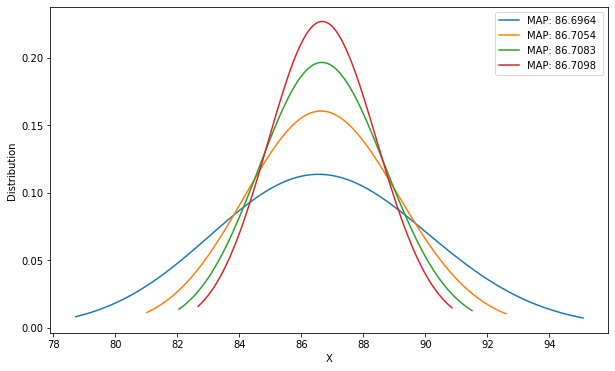

In [93]:
plot_gamma(table)

# Task D

In [94]:
#this function calculates the Mean Absolute Percentage Error
def MAPE(y_pred, y):
  mape = 0
  for x in range(0,len(y)):
      temp = (abs(y[x] - y_pred[x])/y[x])
      mape += temp
  return (mape/len(y))*100

# this function calculates the mean square error
def MSE(y_pred, y):
    error = 0
    for x in range(0,len(y)):
        error += (np.square(y_pred[x] - y[x]))
    return error/len(y)

In [95]:
def plot_graph(d,titlek):
  x=[i for i in range(len(d))]
  y1=d["Actual Value"]
  y2=d["Predicted Value"]
  mape=MAPE(y2,y1)
  mse=MSE(y2,y1)
  plt.plot(x,y1,label="Actual Values")
  plt.plot(x,y2,label="Predicted Values")
  dates=list(map(str,d["Date"]))
  dates=[i[:10] for i in dates]
  plt.xticks(x,dates,rotation="vertical")
  plt.xlabel("Date")
  plt.ylabel("Number of vaccines")
  titlek+=("\n MAPE = "+str(mape)+"%, MSE = "+str(mse))
  plt.title(label=titlek)
  plt.legend()
  plt.show()

## AutoRegression

In [96]:
# this function generates the data required for autoregression
def generate_data(data,n):
  data=list(data["Count"])
  X,y=[],[]
  for i in range(n,len(data)):
    arr=[1]
    arr+=[data[k] for k in range(i-1,i-n-1,-1)]
    y.append(data[i])
    X.append(arr)
  return np.array(X),np.array(y)

#this function gives the beta vector 
def get_beta(X,y):
  X_transpose=np.transpose(X)
  A=np.dot(X_transpose,X)
  B=np.dot(X_transpose,y)
  return np.linalg.solve(A,B)

#this function takes the data and n and performs AutoRegression(n)
def AutoRegression(data,n):
  X,y=generate_data(data,n)
  start,end=datetime.datetime(2021,5,1),datetime.datetime(2021,5,22)
  train_data=data.loc[(data["Date"]>=start) & (data["Date"]< end)]
  start,end=datetime.datetime(2021,5,22-n),datetime.datetime(2021,5,29)
  test_data=data.loc[(data["Date"]>=start )&( data["Date"]< end)]
  X_train,y_train=generate_data(train_data,n)
  X_test,y_test=generate_data(test_data,n)
  beta=get_beta(X_train,y_train)
  y_pred=[]
  for i in range(len(X_test)):
    t=np.array([1]+X_test[i])
    pred=np.dot(t,beta)
    t=np.reshape(t,(1,n+1))
    y_pred.append(pred)
    X_train=np.append(X_train,list(t),axis=0)
    y_train=np.append(y_train,y_test[i])
    beta=get_beta(X_train,y_train)
  d={"Date":list(test_data["Date"])[n:],"Actual Value":list(y_test),"Predicted Value":list(y_pred)}
  return pd.DataFrame(d)


  

### AR(3)

        Date  Actual Value  Predicted Value
0 2021-05-22       17173.0     49073.900452
1 2021-05-23       19270.0     29395.413647
2 2021-05-24         150.0     30469.637078
3 2021-05-25       14265.0     24637.811889
4 2021-05-26        6261.0     20597.314981
5 2021-05-27        4780.0     18839.548943
6 2021-05-28        9416.0     14968.539307


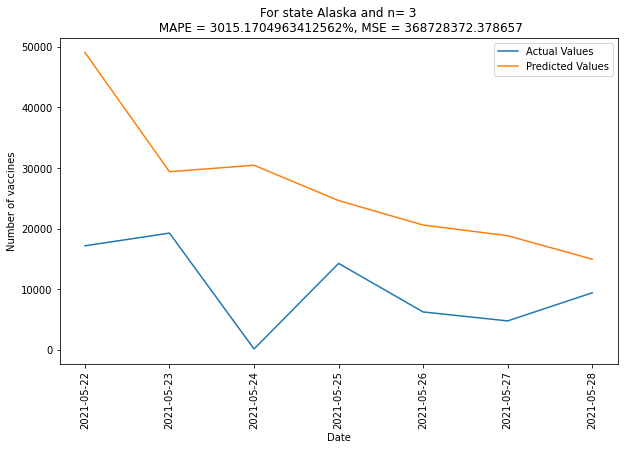


        Date  Actual Value  Predicted Value
0 2021-05-22       17173.0     78976.463523
1 2021-05-23       19270.0     31040.148743
2 2021-05-24         150.0     23720.445976
3 2021-05-25       14265.0     32021.272336
4 2021-05-26        6261.0     13607.287108
5 2021-05-27        4780.0     17972.148863
6 2021-05-28        9416.0     14631.090883


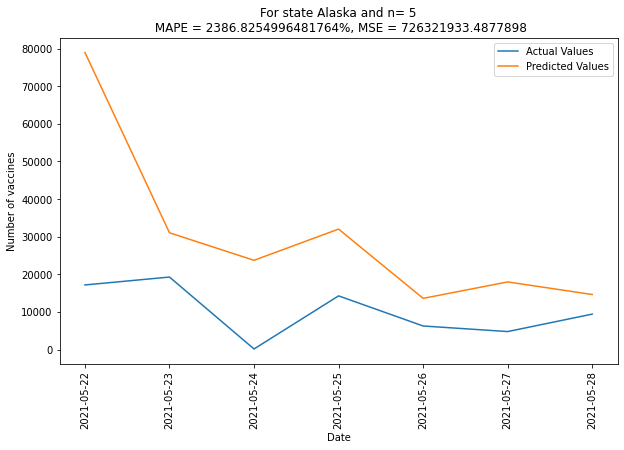


        Date  Actual Value  Predicted Value
0 2021-05-22      336400.0    613689.756305
1 2021-05-23      333684.0    435770.667805
2 2021-05-24      170194.0    398607.372668
3 2021-05-25      107545.0    172242.444442
4 2021-05-26      154889.0    174467.637850
5 2021-05-27      188350.0    205221.218169
6 2021-05-28      205413.0    188796.301537


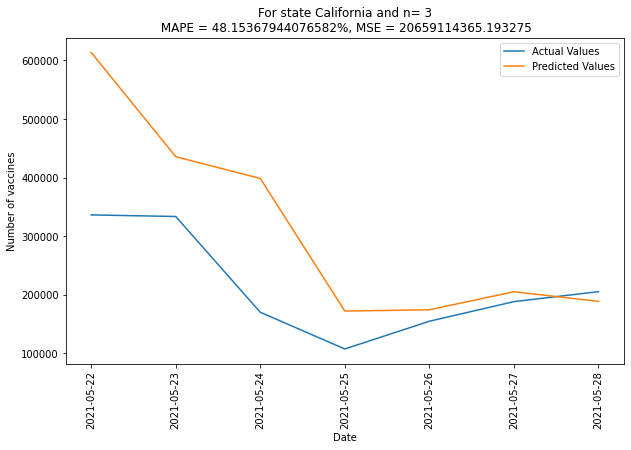


        Date  Actual Value  Predicted Value
0 2021-05-22      336400.0    955525.070589
1 2021-05-23      333684.0    328173.202335
2 2021-05-24      170194.0    352557.254005
3 2021-05-25      107545.0    141027.300687
4 2021-05-26      154889.0    156102.773203
5 2021-05-27      188350.0    170357.281980
6 2021-05-28      205413.0    243564.531669


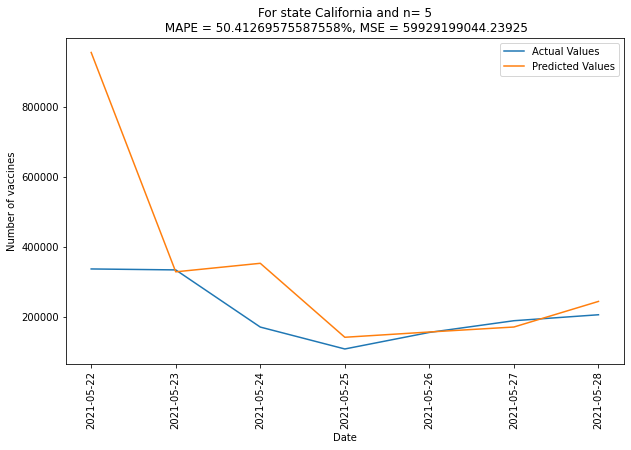

In [97]:
states={0:vaccination_alaska,1:vaccination_cali}
names={0:"Alaska",1:"California"}
values=[3,5]
for state in states:
  for value in values:
    d=AutoRegression(states[state],value)
    title="For state "+names[state]+" and n= "+str(value)
    print(d)
    plot_graph(d,title)
    print()

## EWMA

In [98]:
#This function performs Exponentially Weighted Moving Average
def EWMA(data,alpha):
  start,end=datetime.datetime(2021,5,21),datetime.datetime(2021,5,29)
  test_data=data.loc[(data["Date"]>=start )&( data["Date"]< end)]
  dates=list(test_data["Date"])
  y_test=list(test_data["Count"])
  y_pred=[y_test[0]]
  for i in range(1,len(y_test)):
    pred=(alpha*y_test[i])+(1-alpha)*y_pred[-1]
    y_pred.append(pred)
  d={"Date":dates[1:],"Actual Value":y_test[1:],"Predicted Value":y_pred[1:]}
  return pd.DataFrame(d)

        Date  Actual Value  Predicted Value
0 2021-05-22       17173.0       11750.0000
1 2021-05-23       19270.0       15510.0000
2 2021-05-24         150.0        7830.0000
3 2021-05-25       14265.0       11047.5000
4 2021-05-26        6261.0        8654.2500
5 2021-05-27        4780.0        6717.1250
6 2021-05-28        9416.0        8066.5625


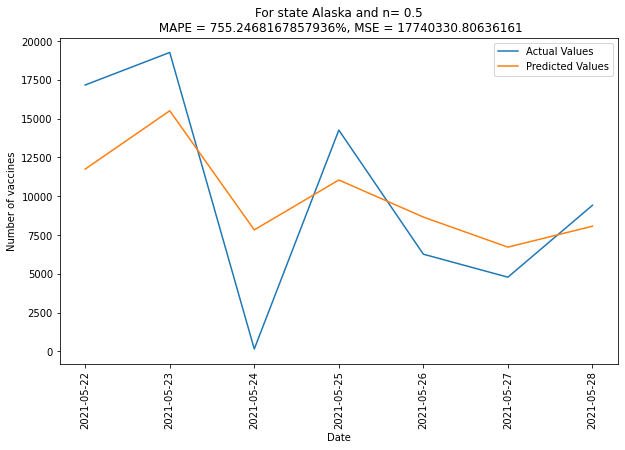


        Date  Actual Value  Predicted Value
0 2021-05-22       17173.0     15003.800000
1 2021-05-23       19270.0     18416.760000
2 2021-05-24         150.0      3803.352000
3 2021-05-25       14265.0     12172.670400
4 2021-05-26        6261.0      7443.334080
5 2021-05-27        4780.0      5312.666816
6 2021-05-28        9416.0      8595.333363


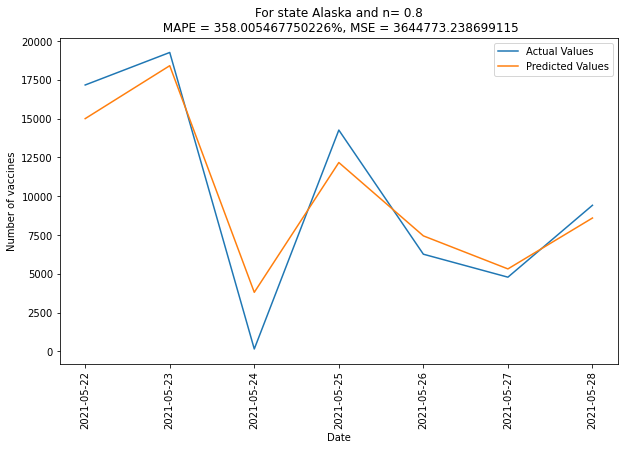


        Date  Actual Value  Predicted Value
0 2021-05-22      336400.0    330235.000000
1 2021-05-23      333684.0    331959.500000
2 2021-05-24      170194.0    251076.750000
3 2021-05-25      107545.0    179310.875000
4 2021-05-26      154889.0    167099.937500
5 2021-05-27      188350.0    177724.968750
6 2021-05-28      205413.0    191568.984375


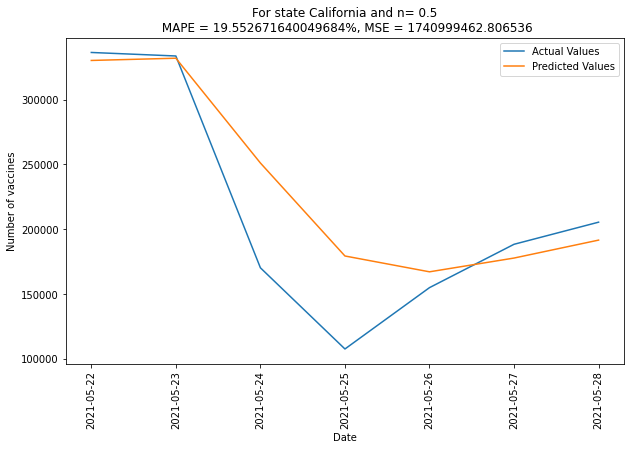


        Date  Actual Value  Predicted Value
0 2021-05-22      336400.0      333934.0000
1 2021-05-23      333684.0      333734.0000
2 2021-05-24      170194.0      202902.0000
3 2021-05-25      107545.0      126616.4000
4 2021-05-26      154889.0      149234.4800
5 2021-05-27      188350.0      180526.8960
6 2021-05-28      205413.0      200435.7792


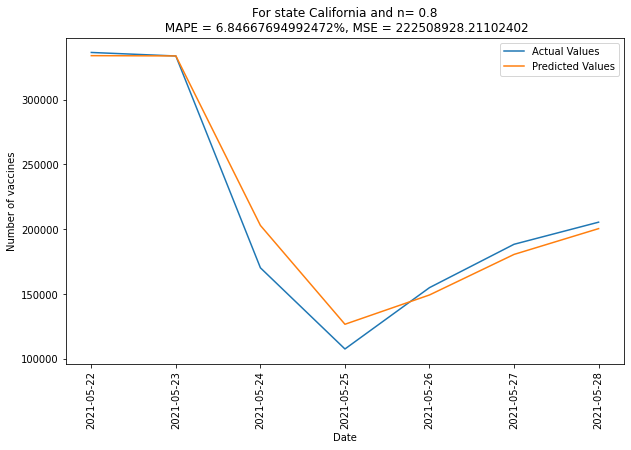

In [99]:
states={0:vaccination_alaska,1:vaccination_cali}
names={0:"Alaska",1:"California"}
values=[0.5,0.8]
for state in states:
  for value in values:
    d=EWMA(states[state],value)
    title="For state "+names[state]+" and n= "+str(value)
    print(d)
    plot_graph(d,title)
    print()

# Task E

In [100]:
sep_start_date , sep_end_date = '2021-09-01', '2021-09-30'
nov_start_date, nov_end_date = '2021-11-01', '2021-11-30'
condition = (vaccination_alaska['Date'].dt.month==9) & (vaccination_alaska['Date'].dt.year==2021)
AL_sep_data = vaccination_alaska.loc[condition]
condition = condition = (vaccination_alaska['Date'].dt.month==11) & (vaccination_alaska['Date'].dt.year==2021)
AL_nov_data = vaccination_alaska.loc[condition]


AL_sep_data=pd.DataFrame(AL_sep_data)
AL_nov_data=pd.DataFrame(AL_nov_data)
AL_sep_data.reset_index(drop=True)

,Date,state,Administered,Admin_Per_100K,Count,Count_Per_100K
0,2021-09-01,AL,4139337,84421,3090.0,0
1,2021-09-02,AL,4158442,84811,19105.0,0
2,2021-09-03,AL,4178419,85218,19977.0,0
3,2021-09-04,AL,4209610,85855,31191.0,0
4,2021-09-05,AL,4216512,85995,6902.0,0
5,2021-09-06,AL,4229402,86258,12890.0,0
6,2021-09-07,AL,4237710,86428,8308.0,0
7,2021-09-08,AL,4252635,86732,14925.0,0
8,2021-09-09,AL,4255847,86798,3212.0,0
9,2021-09-10,AL,4287769,87449,31922.0,0


In [101]:
sep_start_date , sep_end_date = '2021-09-01', '2021-09-30'
nov_start_date, nov_end_date = '2021-11-01', '2021-11-30'
condition = (vaccination_cali['Date'].dt.month==9) & (vaccination_cali['Date'].dt.year==2021)
CA_sep_data = vaccination_cali.loc[condition]

condition = (vaccination_cali['Date'] >= nov_start_date) & (vaccination_cali['Date'] <= nov_end_date)
CA_nov_data = vaccination_cali.loc[condition]


CA_sep_data=pd.DataFrame(CA_sep_data)
CA_nov_data=pd.DataFrame(CA_nov_data)
CA_sep_data.reset_index(drop=True)

,Date,state,Administered,Admin_Per_100K,Count,Count_Per_100K
0,2021-09-01,CA,48109850,121759,97471.0,0
1,2021-09-02,CA,48220341,122039,110491.0,0
2,2021-09-03,CA,48331013,122319,110672.0,0
3,2021-09-04,CA,48434737,122582,103724.0,0
4,2021-09-05,CA,48535491,122837,100754.0,0
5,2021-09-06,CA,48619850,123050,84359.0,0
6,2021-09-07,CA,48668051,123172,48201.0,0
7,2021-09-08,CA,48694320,123239,26269.0,0
8,2021-09-09,CA,48768666,123427,74346.0,0
9,2021-09-10,CA,48873266,123692,104600.0,0


Paired T test for Sept 2021 for CA and AL

In [102]:
merge_sep = pd.merge(CA_sep_data, AL_sep_data, how='inner', on=['Date'])

In [103]:
delta_sept=abs(merge_sep['Count_x']-merge_sep['Count_y'])

In [104]:
import scipy.stats
def compute_paired_t_statistic(x):
  n=len(x)
  x_mean, x_var= np.mean(x), np.var(x)
  denom=np.sqrt(np.sum(np.square(x - x_mean))/(len(x)))
  t=(x_mean-0)/(denom/np.sqrt(n))
  print("u_hat: "+ str(x_mean))
  print("Standard error: "+ str(denom))
  print("T statistic: "+ str(t))
  return t
  
def t_test_paired(a,alpha):
  t=compute_paired_t_statistic(a)
  if abs(t)>scipy.stats.t.ppf(q=1-.05/2,df=28):
    return False
  else:
    return True

In [105]:
t_test_paired(delta_sept,0.05)

u_hat: 74364.13333333333
Standard error: 30892.175791218648
T statistic: 13.184863886332863


False

Paired T test for November 2021 for CA and AL

In [106]:
merge_nov = pd.merge(CA_nov_data, AL_nov_data, how='inner', on=['Date'])

In [107]:
delta_nov=abs(merge_nov['Count_x']-merge_nov['Count_y'])

In [108]:
t_test_paired(delta_nov,0.05)

u_hat: 134998.64285714287
Standard error: 92990.7641897126
T statistic: 7.681899152964259


False


## Result of T 2 sampled Paired testing for mean of no:of vaccines administered  in CA/Al:

Null hypothesis (H0):

Mean of Sept'21 vaccines administered in CA/Al = Mean of Nov'21 vaccines administered

Alternate hypothesis(H1):

Mean of Sept'21 vaccines administered in CA/Al is different from Mean of Nov'21 vaccines administered.

Procedure :

We have taken the alpha = 0.05 n=30 as given in Task and calculated the numerator and denominator of T value in the above t_test_paired function .
Result:

As the T statistic value for vaccines administered in CA/Al around September'21 = 13.184 which is greater than 2.45 we are rejecting the NULL hypothesis.

As the T statistic value for vaccines administered in CA/Al around Nov'21 = 7.68 which is greater than 2.45 we are rejecting the NULL hypothesis.

Is the paired T Test appliable ?

Paired T-Test Assumes that the data X and Y are dependent and diff of(X,Y) data set is normally distributed and as these two assumptions are failing Paired T test is not applicable.


# Exploratory Data Analysis - 1

1.Use your X dataset to check if COVID19 cases/vaccinations had an impact on the X data. State your hypothesis clearly and determine the best tool (from among those learned in class) to apply to your hypotheses. Also, check whether the tool/test is applicable or not. 

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import gamma
import math
import datetime
import warnings
import random
from itertools import permutations
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

In [110]:
total_cases=pd.read_csv("/content/drive/MyDrive/Prob Stats Project Data/cases.csv")#cases dataset
total_vaccinations=pd.read_csv("/content/drive/MyDrive/Prob Stats Project Data/vaccinations.csv")#vaccination dataset
data=pd.read_csv("/content/drive/MyDrive/Prob Stats Project Data/JNJ stock Data.csv")#x dataset

In [111]:
total_vaccinations.rename(columns={"Location":"state"},inplace=True)#renaming the column from location to state in vaccinations file
total_cases.rename(columns={"submission_date":"Date"},inplace=True)#renaming the columns from submission_date to date in cases file

In [112]:
def filter_data(data,states,columns):#filtering the data
  data=data.loc[data["state"].isin(states)]
  return data[columns].reset_index(drop=True)

In [113]:
states=["AL","CA"]#choosing for only the states allocated
columns=["Date","state","new_case","new_death","tot_cases"]
cases=filter_data(total_cases,states,columns)
columns=["Date","state","Administered","Admin_Per_100K"]
vaccinations=filter_data(total_vaccinations,states,columns)

In [114]:
def remove_nulls(data):#removing null values
  data=data[data.select_dtypes(include=[np.number]).ge(0).all(1)]
  return data.dropna(axis=0,how="any")
def convert_date(data):#converting the date format
  data['Date'] =  pd.to_datetime(data['Date'], format=r"%m/%d/%Y")
  return data
def sort_seperate_states(data):#sorting for the assigned states
  a,b=data.loc[data["state"]=="AL"],data.loc[data["state"]=="CA"]
  a.sort_values(by="Date",ignore_index=True,inplace=True)
  b.sort_values(by="Date",ignore_index=True,inplace=True)
  return a,b
def getMonth(data):
  data["month"]=pd.DatetimeIndex(data['Date']).month
  return data
def remove_outliers(value,min_threshold,max_threshold):#removing the outliers
  if value < min_threshold or value > max_threshold:
    return np.nan
  return value

def remove_all_outliers(data,columns):
  for column in columns:
    temp_data=data[column]
    q1=np.percentile(temp_data,25)
    q3=np.percentile(temp_data,75)
    iqr=q3-q1
    min_threshold,max_threshold=q1-(1.5*iqr),q3+(1.5*iqr)
    data[column] = data.apply(lambda x: remove_outliers(x[column],min_threshold, max_threshold), axis=1)
  return remove_nulls(data).reset_index(drop=True)

def get_daily_data(data):
  data.sort_values(by="Date",ignore_index=True,inplace=True)
  t1=data["Administered"][0]
  t2=data["Admin_Per_100K"][0]
  data['Count'] = data.Administered - data.Administered.shift(1)
  data["Count_Per_100K"]=data.Admin_Per_100K-data.Admin_Per_100K.shift(1)
  data["Count"][0]=t1
  data["Count_Per_100K"]=t2
  return data

def transform_data(data):
  data=remove_nulls(data)
  data=remove_all_outliers(data,["new_case","new_death"])
  data=convert_date(data)
  data=getMonth(data)
  data_alaska,data_cali=sort_seperate_states(data)
  return data_alaska,data_cali


In [115]:
def convert(row):
  date=str(row["Date"])
  if "-" in date:
    date=pd.to_datetime(date,format=r"%d-%m-%Y")
  else:
    date=pd.to_datetime(date,format=r"%m/%d/%Y")
  return date
def remove_commas(row):
  for column in ["Volume"]:
    row[column]=row[column].replace(",","")
  return row

data["Date"]=data.apply(convert,axis=1)
data=data.apply(remove_commas,axis=1)
for column in ["Open","High","Low","Close"]:
  data[column]=pd.to_numeric(data[column])

In [116]:
cases_alaska,cases_cali=transform_data(cases)

In [117]:
def transform_data_Vacc(data):
  data=remove_nulls(data)
  data=convert_date(data)
  data_alaska,data_cali=sort_seperate_states(data)
  data_alaska=get_daily_data(data_alaska)
  data_cali=get_daily_data(data_cali)
  data_alaska=remove_all_outliers(data_alaska,["Count","Count_Per_100K"])
  data_cali=remove_all_outliers(data_cali,["Count","Count_Per_100K"])
  return data_alaska,data_cali

In [118]:
vaccination_alaska,vaccination_cali=transform_data_Vacc(vaccinations)

In [119]:

data=data.apply(remove_commas,axis=1)
for column in ["Open","High","Low","Close","Volume"]:
  data[column]=pd.to_numeric(data[column])


def remove_nulls(data):
  data=data[data.select_dtypes(include=[np.number]).ge(0).all(1)]
  return data.dropna(axis=0,how="any")

def remove_outliers(value,min_threshold,max_threshold):
  if value < min_threshold or value > max_threshold:
    return np.nan
  return value

def remove_all_outliers(data,columns):
  outlier_index = []
  for column in columns:
    temp_data=data[column]
    print(temp_data)
    q1=np.percentile(temp_data,25)
    q3=np.percentile(temp_data,75)
    iqr=q3-q1
    min_threshold,max_threshold=q1-(1.5*iqr),q3+(1.5*iqr)
    #Determine a list of indices of outliers for feature col
    outlier_list_col = data[(data[column] > max_threshold) | (data[column] < min_threshold)]
    print("Outliers in Column "+str(column) + " : " + str(len(outlier_list_col)))
    data[column] = data.apply(lambda x: remove_outliers(x[column],min_threshold, max_threshold), axis=1)
    plt.scatter(data['Date'],data[column])
    plt.scatter(outlier_list_col['Date'],outlier_list_col[column])
    plt.rcParams["figure.figsize"] = (10,6)
    plt.show()
  return remove_nulls(data).reset_index(drop=True)

0      128.81
1      148.29
2      147.19
3      140.38
4      151.52
        ...  
593    182.10
594    183.46
595    180.46
596    176.85
597    178.08
Name: Close, Length: 598, dtype: float64
Outliers in Column Close : 1


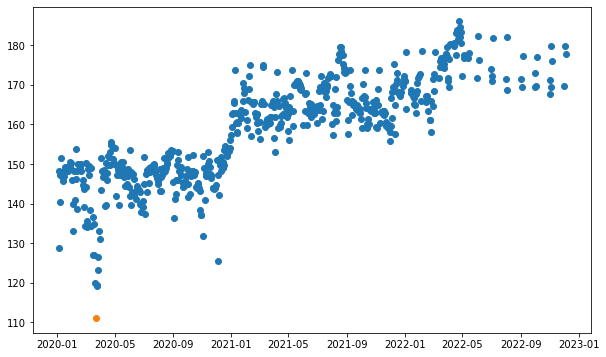

0      127.70
1      149.62
2      147.29
3      140.69
4      153.87
        ...  
593    184.24
594    182.25
595    182.50
596    178.70
597    176.85
Name: Open, Length: 598, dtype: float64
Outliers in Column Open : 3


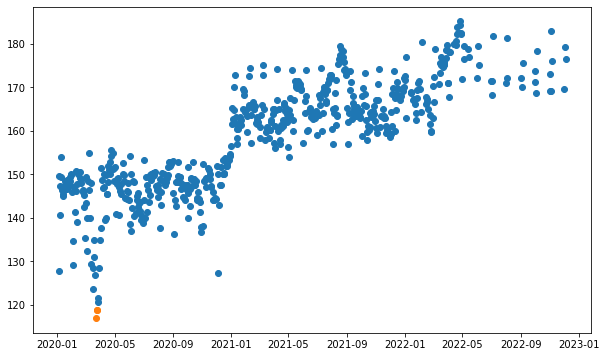

0      130.23
1      149.67
2      148.34
3      141.39
4      154.08
        ...  
593    184.82
594    184.50
595    182.55
596    178.89
597    179.13
Name: High, Length: 598, dtype: float64
Outliers in Column High : 2


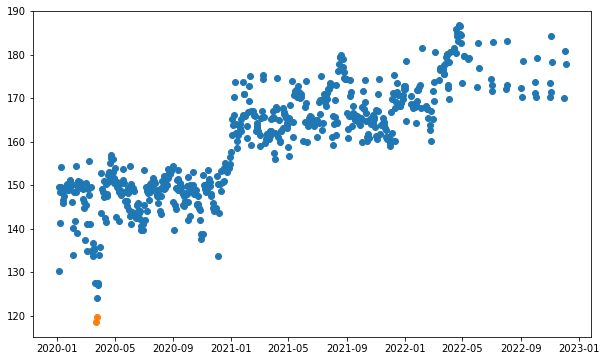

0      125.50
1      146.79
2      146.01
3      140.06
4      150.07
        ...  
593    181.74
594    181.92
595    180.20
596    175.80
597    176.17
Name: Low, Length: 598, dtype: float64
Outliers in Column Low : 3


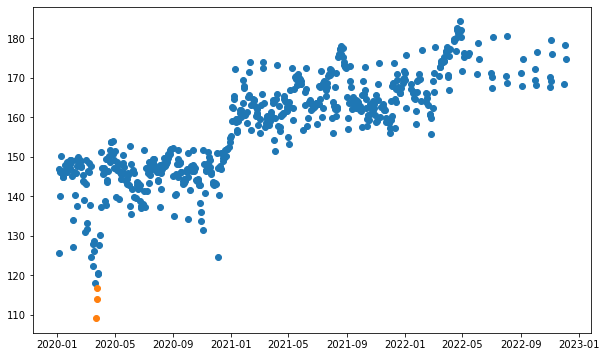

0      12606080
1       7308960
2       6142580
3       6175020
4       6309237
         ...   
593    11090330
594     9405147
595     8464103
596     7732163
597     5516706
Name: Volume, Length: 598, dtype: int64
Outliers in Column Volume : 41


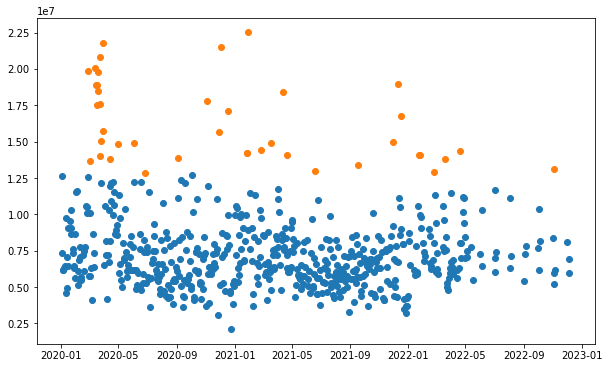

          Date    Open    High     Low   Close      Volume
0   2020-01-04  127.70  130.23  125.50  128.81  12606080.0
1   2020-01-05  149.62  149.67  146.79  148.29   7308960.0
2   2020-01-06  147.29  148.34  146.01  147.19   6142580.0
3   2020-01-07  140.69  141.39  140.06  140.38   6175020.0
4   2020-01-09  153.87  154.08  150.07  151.52   6309237.0
..         ...     ...     ...     ...     ...         ...
552 2022-04-27  184.24  184.82  181.74  182.10  11090330.0
553 2022-04-28  182.25  184.50  181.92  183.46   9405147.0
554 2022-04-29  182.50  182.55  180.20  180.46   8464103.0
555 2022-05-13  178.70  178.89  175.80  176.85   7732163.0
556 2022-05-16  176.85  179.13  176.17  178.08   5516706.0

[557 rows x 6 columns]


In [120]:
data=remove_all_outliers(data,["Close","Open","High","Low","Volume"])
print(data)

In [121]:
dataframe=data.merge(cases_alaska, how='inner', on='Date')#performing merging on date column where state is Alaska
dataframe.head(5)

,Date,Open,High,Low,Close,Volume,state,new_case,new_death,tot_cases,month
0,2020-02-01,145.87,146.02,145.08,145.97,5634469.0,AL,0.0,0.0,0,2
1,2020-02-03,134.78,140.13,134.01,140.02,11508230.0,AL,0.0,0.0,0,2
2,2020-02-04,129.12,134.00,127.22,133.15,11594460.0,AL,0.0,0.0,0,2
3,2020-02-06,147.06,148.35,146.12,148.25,6078311.0,AL,0.0,0.0,0,2
4,2020-02-07,141.25,141.84,140.33,140.97,5152238.0,AL,0.0,0.0,0,2


In [122]:
dataframe_cali=data.merge(cases_cali, how='inner', on='Date')#performing merging on date column where state is California
dataframe_cali.head(5)

,Date,Open,High,Low,Close,Volume,state,new_case,new_death,tot_cases,month
0,2020-02-01,145.87,146.02,145.08,145.97,5634469.0,CA,0.0,0.0,0,2
1,2020-02-03,134.78,140.13,134.01,140.02,11508230.0,CA,3.0,0.0,6,2
2,2020-02-04,129.12,134.00,127.22,133.15,11594460.0,CA,0.0,0.0,6,2
3,2020-02-06,147.06,148.35,146.12,148.25,6078311.0,CA,0.0,0.0,6,2
4,2020-02-07,141.25,141.84,140.33,140.97,5152238.0,CA,0.0,0.0,6,2


##Pearson test

** total cases plot**


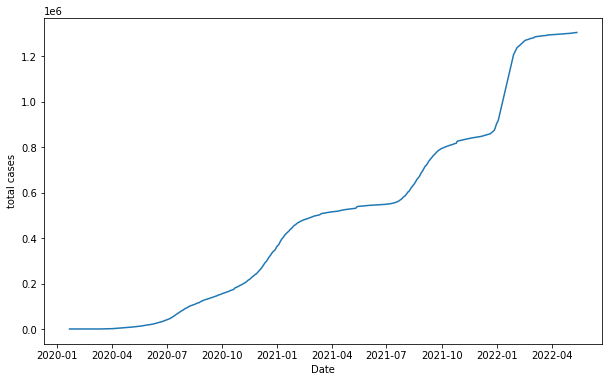

**JNJ Stock market**


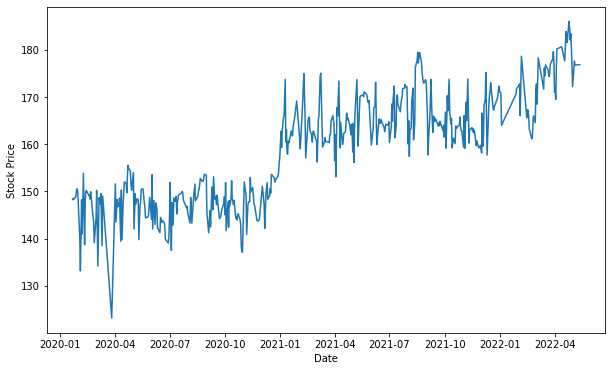

In [123]:
dataframe_alaska=dataframe.sort_values(by=['Date'])
print("** total cases plot**" )
#plt.figure(figsize=(15,10))
plt.plot(dataframe_alaska['Date'], dataframe_alaska['tot_cases'])
plt.xlabel('Date')
plt.ylabel('total cases')
plt.show()
print("**JNJ Stock market**" )
#plt.figure(figsize=(15,10))
plt.plot(dataframe_alaska['Date'], dataframe_alaska['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [124]:
handle = 'tot_cases'
test_handle = 'Close'

stocks_close_price_mean = np.mean(dataframe_alaska[test_handle])
covid_total_confirmed_mean = np.mean(dataframe_alaska[handle])
numer = 0
denom_x = 0 
denom_y = 0 
for i in range(dataframe_alaska.shape[0]):
  x_minus_Xavg = np.array(dataframe_alaska[test_handle])[i] - stocks_close_price_mean
  y_minus_Yavg = np.array(dataframe_alaska[handle])[i] - covid_total_confirmed_mean
  numer = numer + (x_minus_Xavg * y_minus_Yavg)
  denom_x =  denom_x + np.square(x_minus_Xavg)
  denom_y =  denom_y + np.square(y_minus_Yavg)

coeff = numer / np.sqrt(denom_x * denom_y)
print("Alaska:- ",coeff)
#as coeff is > 0.5 . They are positively correlated

Alaska:-  0.8421261353588076


** Covid new cases Data**


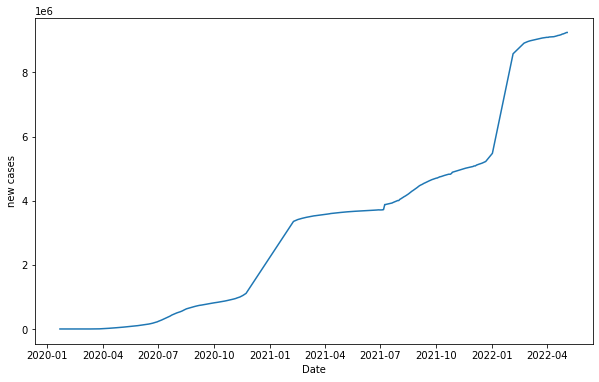

** Stock market Data**


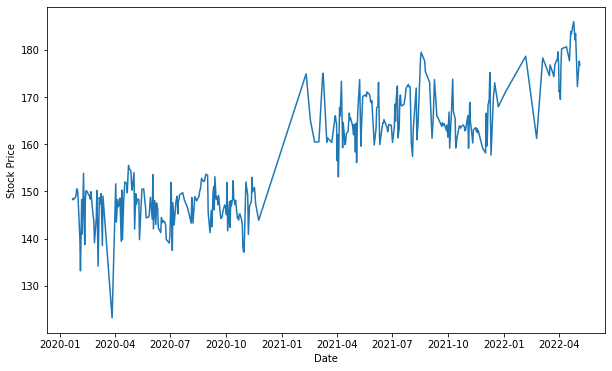

In [125]:
dataframe_cali=dataframe_cali.sort_values(by=['Date'])
print("** Covid new cases Data**" )
#plt.figure(figsize=(15,10))
plt.plot(dataframe_cali['Date'], dataframe_cali['tot_cases'])
plt.xlabel('Date')
plt.ylabel('new cases')
plt.show()

print("** Stock market Data**" )
#plt.figure(figsize=(15,10))
plt.plot(dataframe_cali['Date'], dataframe_cali['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [126]:
handle = 'tot_cases'
test_handle = 'Close'

stocks_close_price_mean = np.mean(dataframe_cali[test_handle])
covid_total_confirmed_mean = np.mean(dataframe_cali[handle])
numer = 0
denom_x = 0 
denom_y = 0 
for i in range(dataframe_cali.shape[0]):
  x_minus_Xavg = np.array(dataframe_cali[test_handle])[i] - stocks_close_price_mean
  y_minus_Yavg = np.array(dataframe_cali[handle])[i] - covid_total_confirmed_mean
  numer = numer + (x_minus_Xavg * y_minus_Yavg)
  denom_x =  denom_x + np.square(x_minus_Xavg)
  denom_y =  denom_y + np.square(y_minus_Yavg)

coeff = numer / np.sqrt(denom_x * denom_y)
print("California:- ",coeff)
#as coeff is > 0.5 . They are positively correlated

California:-  0.8756818042485894


##K-S Test


In [127]:
def eCDF_value(state1):
    state_1 = len(state1)
    listvalues = sorted(state1)
    value=1/(state_1)
    X = []
    f_x = []
    cdf=value

    for i in range(0,state_1):
        X = X + [listvalues[i]]
        f_x = f_x + [cdf]
        cdf+=value

    return X,f_x

In [128]:
def ks_test(state1,state2,X1, f_X1, X2, f_X2):
  i=0
  j=0
  maxi1=0
  while i<len(state1) and j<len(state2):
    if state1[i] < state2[j]:
      if j==0:
        F_x_cap=0
      else:
        F_x_cap = f_X2[X2.index(state2[j-1])]
      if i==0:
        F_y_left=0
      else:
        F_y_left = f_X1[X1.index(X1[i-1])]
      if i==len(X1)-1:
        F_y_right=1
      else:
        F_y_right=f_X1[X1.index(state1[i])]
      maxi_temp=max(abs(F_x_cap-F_y_left),abs(F_x_cap-F_y_right))
      if maxi_temp>maxi1:
        maxi1=maxi_temp
        index=i
      i+=1
    else:
      j+=1

  print("K-S statistic is " + str(maxi1)+" and point of max difference is "+str(state1[index]))
  return maxi1


In [129]:
handle = 'tot_cases'
test_handle = 'Close'
handle_data = dataframe_cali['tot_cases']
test_handle_data = dataframe_cali[test_handle]
X1, f_X1 = eCDF_value(handle_data)
X2, f_X2 = eCDF_value(test_handle_data)
KS_p_value_deaths = ks_test(handle_data.tolist(), test_handle_data.tolist(),X1, f_X1, X2, f_X2)


K-S statistic is 0.6141304347826071 and point of max difference is 177


In [130]:
handle = 'tot_cases'
test_handle = 'Close'
handle_data = dataframe_alaska['tot_cases']
test_handle_data = dataframe_alaska[test_handle]
X1, f_X1 = eCDF_value(handle_data)
X2, f_X2 = eCDF_value(test_handle_data)
KS_p_value_deaths = ks_test(handle_data.tolist(), test_handle_data.tolist(),X1, f_X1, X2, f_X2)

K-S statistic is 0.0684931506849315 and point of max difference is 4


##Permutation Test


In [131]:
def permutation_test_function(X, Y, n=5000, threshold=0.05):
    T_obs = abs(np.mean(X) - np.mean(Y)) 
    xy = np.append(X,Y)
    p_value = 0.0
    for i in range(n):
        permutation = np.random.permutation(xy)
        X1 = permutation[:len(X)]
        Y1 = permutation[len(X):]
        Ti = abs(np.mean(X1) - np.mean(Y1))
#         print(Ti, T_obs)
        if(Ti > T_obs):
            p_value += 1.0
    
#     p_value = p_value/float(np.math.factorial(n))
    p_value = p_value/n
    print("The p-value is: ", p_value)
    if(p_value <= threshold):
        print("==> Reject the Null Hypothesis")
    else:
        print("==> Accept the Null Hypothesis")
    return

In [132]:
dataframe_alaska['tot_cases_abs'] = abs(dataframe_alaska['tot_cases'])
dataframe_alaska['Close_abs'] = abs(dataframe_alaska['Close'])

In [133]:
total_cases_abs = dataframe_alaska['tot_cases_abs'].tolist()
close_abs = dataframe_alaska['Close_abs'].tolist() 

In [134]:
print("--------For Alaska--------")
permutation_test_function(total_cases_abs, close_abs)

--------For Alaska--------
The p-value is:  0.0
==> Reject the Null Hypothesis


In [135]:
dataframe_cali['tot_cases_abs'] = abs(dataframe_cali['tot_cases'])
dataframe_cali['Close_abs'] = abs(dataframe_cali['Close'])

In [136]:
total_cases_cali_abs = dataframe_cali['tot_cases_abs'].tolist()
close_abs = dataframe_cali['Close_abs'].tolist() 

In [137]:
print("--------For Cali--------")
permutation_test_function(total_cases_cali_abs, close_abs)

--------For Cali--------
The p-value is:  0.0
==> Reject the Null Hypothesis


# Exploratory Analysis - 2

In [138]:
total_cases=pd.read_csv("/content/drive/MyDrive/Prob Stats Project Data/cases.csv")
total_cases.rename(columns={"submission_date":"Date"},inplace=True)

In [139]:
def clean_data(data):
  data=remove_nulls(data)
  data=convert_date(data)
  return data

In [140]:
total_cases=clean_data(total_cases)

In [141]:
def print_(data,filter):
  cases=data[["Date",filter]]
  cases=cases.sort_values(by="Date").reset_index(drop=True)
  cases=cases.groupby("Date").sum()
  x=[i for i in range(len(cases))]
  y=list(cases[filter])
  # plt.figure(figsize=(12,5))
  plt.plot(x,y)
  plt.xlabel("Days")
  s="Cases" if filter=="new_case" else "Deaths"
  plt.ylabel("Number of "+s)
  plt.title("Number of {} each day".format(s))
  plt.show()

In [142]:
def compute_weekly(data,filter):
  cases=data[["Date",filter]]
  cases=cases.sort_values(by="Date").reset_index(drop=True)
  cases=cases.groupby("Date").sum()
  cases=cases.reset_index(drop=True)
  cases["Day"]=[i for i in range(1,len(cases)+1)]
  cases=cases[filter].groupby((cases['Day'] - 1) // 7).sum().reset_index(drop=True)
  return list(cases)

In [143]:
def print_weekly(data,filter):
  data=compute_weekly(data,filter)
  x=[i for i in range(len(data))]
  plt.plot(x,data)
  plt.xlabel("Weeks")
  s="Cases" if filter=="new_case" else "Deaths"
  plt.ylabel("Number of "+s)
  plt.title("Number of {} each week".format(s))
  plt.show()

In [144]:
def print_lockdown(data,day,filter):
  cases=data[["Date",filter]]
  cases=cases.sort_values(by="Date").reset_index(drop=True)
  cases=cases.groupby("Date").sum()
  x=[i for i in range(day)]
  y=list(cases[filter])
  plt.plot(x,y[:day],label="Before Lockdown")
  x=[i for i in range(day,day+100)]
  plt.plot(x,y[day:day+100],label="After Lockdown")
  plt.xlabel("Days")
  s="Cases" if filter=="new_case" else "Deaths"
  plt.ylabel("Number of "+s)
  plt.title("Number of {} each day".format(s))
  plt.legend()
  plt.show()



In [145]:
def print_waves(data,waves,filter):
  cases=data[["Date",filter]]
  cases=cases.sort_values(by="Date").reset_index(drop=True)
  cases=cases.groupby("Date").sum()
  x=[i for i in range(len(cases))]
  y=list(cases[filter])
  plt.figure(figsize=(14,5))
  plt.plot(x,y)
  for i,d in enumerate(waves):
    if i%2==0:
      color="b"
      t="Start of the Wave"
    else:
      color="r"
      t="End of the Wave"
    plt.axvline(x=d,ymin=0.03,ymax=0.6,color=color,linestyle='--',linewidth=1.5,label=t)
    if i<2:
      plt.legend()
  plt.xlabel("Days")
  s="Cases" if filter=="new_case" else "Deaths"
  plt.ylabel("Number of "+s)
  plt.title("Highlighting the waves")
  plt.show()


In [146]:
def generate_data(l,a,b,T_obs):
  print("T_obs",T_obs)
  def find_xmean(row):
    return sum(row["X"])/len(row["X"])
  def find_ymean(row):
    return sum(row["Y"])/len(row["Y"])
  def finddiff(row):
    return round(abs(row["X_mean"]-row["Y_mean"]),2)
  def solve(row):
    return 1 if row["T = |X_mean - Y_mean |"] > T_obs else 0
  n=len(l)
  X,Y=[],[]
  for i in range(n):
    X.append(l[i][:a])
    Y.append(l[i][a:])
  data=pd.DataFrame()
  
  data["X"],data["Y"]=X,Y
  data["X_mean"] = data.apply(find_xmean, axis = 1)
  data["Y_mean"] = data.apply(find_ymean, axis = 1)
  data["T = |X_mean - Y_mean |"] = data.apply(finddiff,axis = 1)
  data["I (T > T_obs)"] = data.apply(solve,axis = 1)
  return data

In [147]:
def perm_generator(seq):
  seen = set()
  length = len(seq)
  while True:
      perm = tuple(random.sample(seq, length))
      if perm not in seen:
          seen.add(perm)
          yield perm   
def p_value(data):
  return data.iloc[:,-1].sum()/len(data)
def get_p_value(data_alaska,data_cali,n):
  a,b=len(data_alaska),len(data_cali)
  data=data_alaska+data_cali
  rand_perms = perm_generator(data)
  permlist= [next(rand_perms) for _ in range(n)]
  permlist=list(map(list,permlist))
  T_obs = abs(np.mean(data_alaska)-np.mean(data_cali))
  data=generate_data(permlist,a,b,T_obs)
  return p_value(data)
def permutation_test(X,Y,alpha):
  a,b = len(X),len(Y)
  n=min(math.factorial(a+b),10000)
  p=get_p_value(X,Y,n)
  print("P Value:",p)
  if p < alpha :
    return False
  else:
    return True

## CASES

In [148]:
filter="new_case"

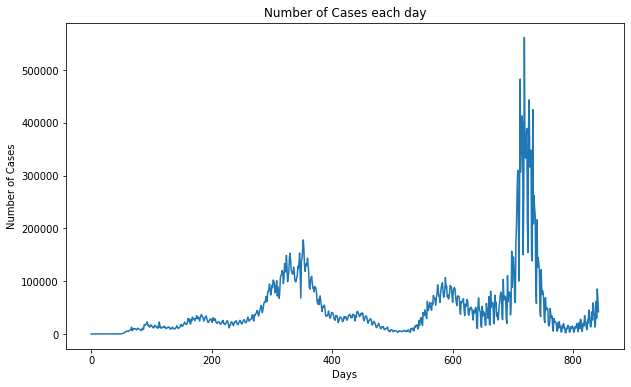

In [149]:
print_(total_cases,filter)

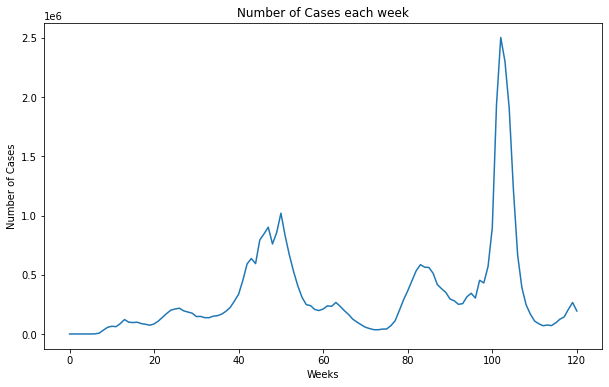

In [150]:
print_weekly(total_cases,filter)

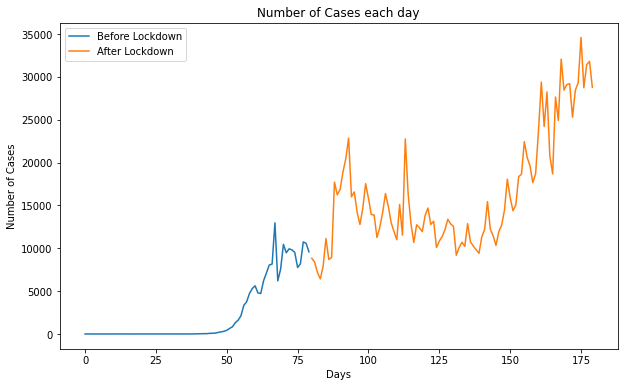

In [151]:
print_lockdown(total_cases,80,filter)

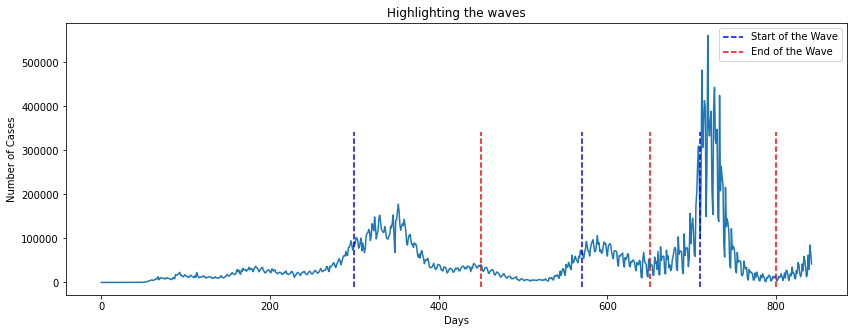

In [152]:
waves=[300,450,570,650,710,800]
print_waves(total_cases,waves,filter)

In [153]:
start1,end1,start2,end2=300,450,710,800
cases=total_cases[["Date","new_case"]]
cases=cases.sort_values(by="Date").reset_index(drop=True)
cases=cases.groupby("Date").sum()

In [154]:
dist1=list(cases["new_case"])[start1:end1]
dist2=list(cases["new_case"])[start2:end2]

In [155]:
permutation_test(dist1,dist2,0.05)

T_obs 46693.56222222223
P Value: 0.0003


False

## Deaths

In [156]:
filter="new_death"

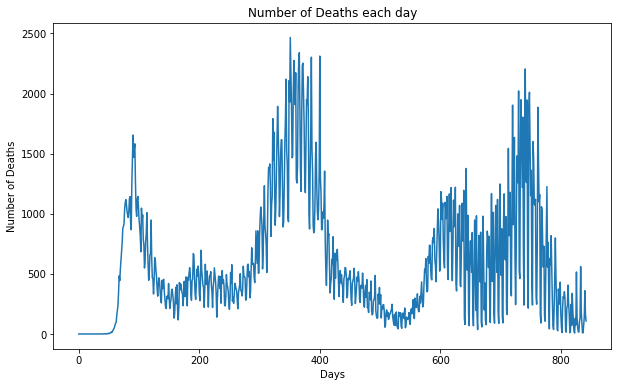

In [157]:
print_(total_cases,filter)

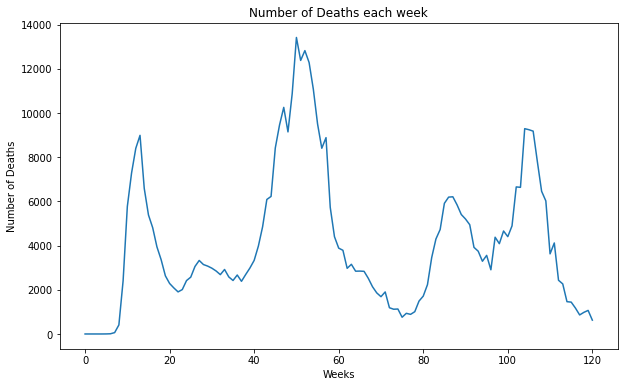

In [158]:
print_weekly(total_cases,filter)

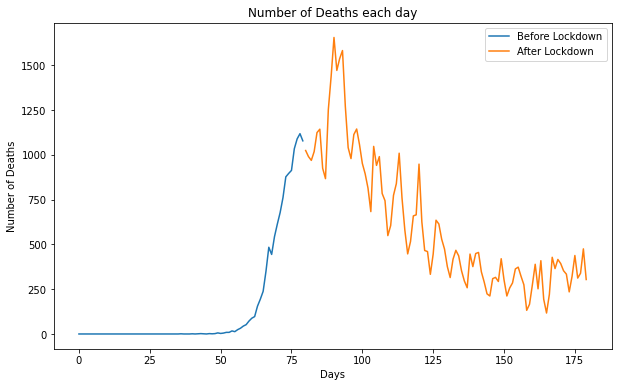

In [159]:
print_lockdown(total_cases,80,filter)

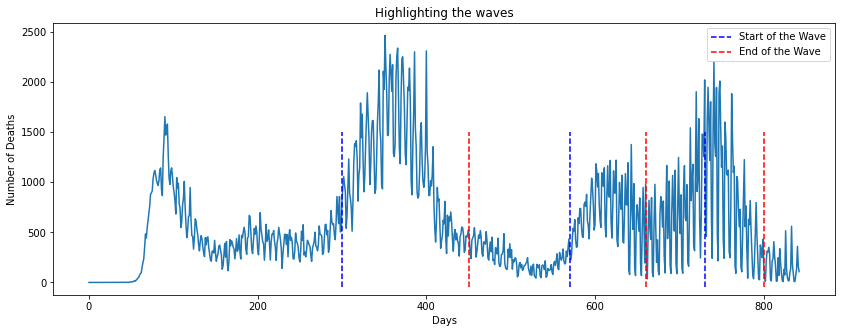

In [160]:
waves=[300,450,570,660,730,800]
print_waves(total_cases,waves,filter)

In [161]:
start1,end1,start2,end2=300,450,710,800
cases=total_cases[["Date","new_case"]]
cases=cases.sort_values(by="Date").reset_index(drop=True)
cases=cases.groupby("Date").sum()

In [162]:
dist1=list(cases["new_case"])[start1:end1]
dist2=list(cases["new_case"])[start2:end2]

In [163]:
permutation_test(dist1,dist2,0.05)

T_obs 46693.56222222223
P Value: 0.0004


False

Deaths and Cases

In [164]:
data=total_cases[["Date","new_case","new_death"]]

In [165]:
data=clean_data(data)

In [166]:
data=data.sort_values(by="Date").reset_index(drop=True)

In [167]:
data=data.groupby("Date").sum()

In [168]:
permutation_test(list(data["new_case"]),list(data["new_death"]),0.05)

T_obs 47430.16725978648
P Value: 0.0


False

In [169]:
cases=total_cases[["Date","new_case","new_death"]]

In [170]:
cases=total_cases[["Date","new_case","new_death"]]
cases=cases.sort_values(by="Date").reset_index(drop=True)
cases=cases.groupby("Date").sum()

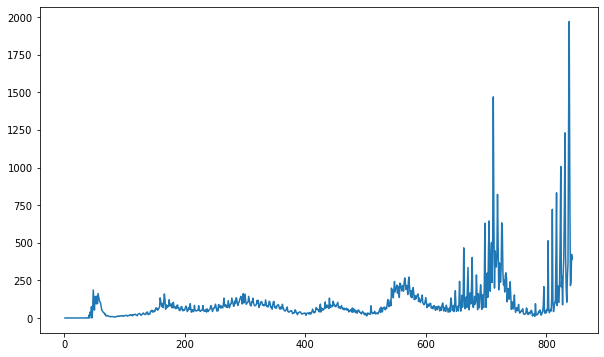

In [171]:
x=[i for i in range(1,len(cases)+1)]
y1=list(cases["new_case"])
y2=list(cases["new_death"])
y=[y1[i]/y2[i] if y2[i]!=0 else 0 for i in range(len(x))]
plt.plot(x,y)